# Idea

Basically, I'd like to do some simple tests on "how can we establish the efficacy of our period-finding method?". I think it would be effective to do two simple things for now:

1. Try lots of different amplitudes (at a given frequency) and see how low we have to go before the period isn't readily identifiable
2. Try lots of different periods (at a given amplitude) and see what frequencies are recoverable and what aren't.

Then, eventually, we'll want to do a grid to see if these two things depend on each other. We'll also want to investigate the effects of "survey" (WSERV5 vs 7 vs 8), spatial location (esp. which footprint), and source brightness / photometric noise.

In [1]:
# for a simple object, let's load its data, inject signals, and see what happens.

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle

plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore')

<ErrorbarContainer object of 3 artists>

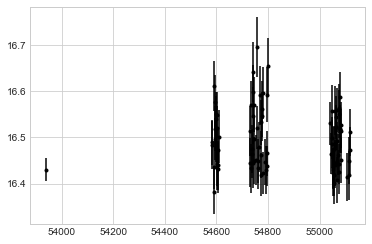

In [3]:
# load data
times = np.loadtxt("sample_k_dates.txt")
mags = np.loadtxt("sample_k_mags.txt")
errs = np.loadtxt("sample_k_errs.txt")


plt.errorbar(times, mags, yerr=errs, fmt='k.', )

In [4]:
from wuvars.analysis.periods import f_max, f_min, N_eval

In [5]:
freq = np.linspace(f_min, f_max, N_eval)

ls = LombScargle(times, mags, dy=errs)
power = ls.power(freq)

min_freq = 1/100
power[freq<min_freq] = 0

fmax = freq[np.nanargmax(power)]
fap = ls.false_alarm_probability(np.nanmax(power))
print(f"FAP of peak: {fap:.2e}. Freq: {fmax:.2f} day^-1 (Period: {24. / fmax:.2f} hours)")

FAP of peak: 1.89e-02. Freq: 1.80 day^-1 (Period: 13.33 hours)


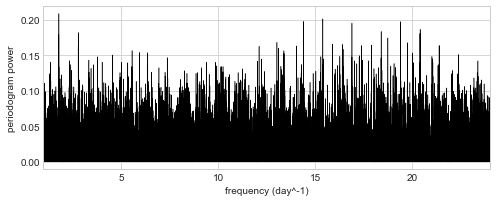

In [6]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(freq, power, '-k', rasterized=True, lw=0.5)
ax.set(xlim=(1, 24),
       xlabel='frequency (day^-1)',
       ylabel='periodogram power');

[0.01       0.01184611 0.01403303 0.01662369 0.0196926  0.02332808
 0.0276347  0.03273637 0.03877987 0.04593906 0.05441992 0.06446644
 0.07636766 0.09046598 0.107167   0.12695121 0.15038781 0.17815107
 0.21103973 0.25      ]
Injected Amplitude: 0.010. FAP of peak: 2.83e-02. Freq: 1.801 day^-1 (Period: 0.56 days)
Injected Amplitude: 0.012. FAP of peak: 3.14e-02. Freq: 1.801 day^-1 (Period: 0.56 days)
Injected Amplitude: 0.014. FAP of peak: 3.58e-02. Freq: 1.801 day^-1 (Period: 0.56 days)
Injected Amplitude: 0.017. FAP of peak: 3.75e-02. Freq: 16.901 day^-1 (Period: 0.06 days)
Injected Amplitude: 0.020. FAP of peak: 4.01e-02. Freq: 16.901 day^-1 (Period: 0.06 days)
Injected Amplitude: 0.023. FAP of peak: 4.45e-02. Freq: 16.901 day^-1 (Period: 0.06 days)
Injected Amplitude: 0.028. FAP of peak: 5.18e-02. Freq: 16.901 day^-1 (Period: 0.06 days)
Injected Amplitude: 0.033. FAP of peak: 1.40e-02. Freq: 2.164 day^-1 (Period: 0.46 days)
Injected Amplitude: 0.039. FAP of peak: 2.01e-03. Freq: 2.1

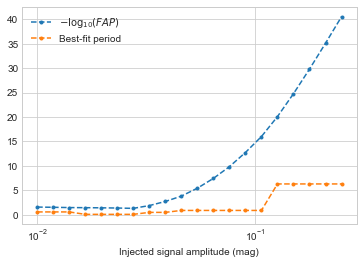

In [7]:
amplitudes = (0.01, 0.1, 1, 10)
amplitudes = np.logspace(-2, np.log10(0.25), 20)
print(amplitudes)

found_period = []
found_fap = []

for amp in amplitudes:
    
    sin_mags = amp * np.sin(times) + mags
    
    ls = LombScargle(times, sin_mags, dy=errs)
    power = ls.power(freq)

    min_freq = 1/100
    power[freq<min_freq] = 0

    fmax = freq[np.nanargmax(power)]
    fap = ls.false_alarm_probability(np.nanmax(power))
    print(f"Injected Amplitude: {amp:.3f}. FAP of peak: {fap:.2e}. Freq: {fmax:.3f} day^-1 (Period: {1. / fmax:.2f} days)")    
    
    found_period.append(1/fmax)
    found_fap.append(fap)
    
plt.plot(amplitudes, -np.log10(found_fap), '.--', label=r'$-\log_{10}(FAP)$')
plt.plot(amplitudes, found_period, '.--', label='Best-fit period')
plt.xlabel("Injected signal amplitude (mag)")
plt.semilogx()
plt.legend()
    


In [8]:
np.median(errs)

0.04999758116900921

In [55]:
%run ../period_recovery.py

In [11]:
from wuvars.data import spreadsheet, photometry
from wuvars.analysis.variability_selection import sq0, sq1, sq2

dat = photometry.group_wserv_v2(photometry.load_wserv_v2(8))
spread = spreadsheet.load_wserv_v2(8)

# wserv_ids = [5, 7, 8, 11]
# n_min_list = [35, 80, 55, 65]
# n_max_list = [90, 160, 80, 100]

n_min = 55
n_max = 80

# min_Stetson_list = [3, 1.6, 1.6, 4]

# SFR_names = ["Orion Nebula Cluster", "NGC 1333", "IC 348", "Mon R2"]
# SFR_dict = {x: y for x, y in zip(wserv_ids, SFR_names)}

q0 = sq0(spread, n_min, n_max)
q1 = sq1(spread, n_min, n_max)
q2 = sq2(spread, n_min, n_max)

Loading WSERV8 photometry data... DONE (elapsed time: 0.16s)


In [12]:
q2_bright = (spread[q2]['mean']['KAPERMAG3'] < 15)
q2_bright_spread = spread[q2][q2_bright]

q2_bright_nonvariable  = (spread[q2]['mean']['KAPERMAG3'] < 15) & (spread[q2]['variability']['Stetson_JHK'] < 0.8) & (spread[q2]['variability']['Stetson_JHK'] > 0.0)
q2_bright_nonvariable_spread = spread[q2][q2_bright_nonvariable]


In [14]:
all_sids = np.unique(q2_bright_spread.index)

all_nonvariable_sids = np.unique(q2_bright_spread.index)

sids = np.random.choice(all_sids, 40)
print(sids)

[44989782481948 44989782500972 44989782485263 44989782432381
 44989782457939 44989782443457 44989782490316 44989782485292
 44989782459130 44989782495773 44989782442090 44989782490031
 44989782476330 44989782462936 44989782495326 44989782479095
 44989782467888 44989782469734 44989782480673 44989782482157
 44989782505928 44989782450561 44989782452767 44989782501363
 44989782497368 44989782501339 44989782458789 44989782469071
 44989782490951 44989782480544 44989782486949 44989782474631
 44989782446935 44989782500748 44989782442330 44989782494526
 44989782469913 44989782457528 44989782506704 44989782466854]


In [15]:
from datetime import datetime

periods6 = [1/23, 1/17, 1/11, 0.1, 1/7, 0.25, 0.307, 0.35, 0.407, 0.45, 0.507, 0.607, 0.707, 0.807, 0.907, 1.0, 1.107, 1.207, 1.3507, 1.5, 1.707, 2, 2.1, 2.207, 2.5, 3.07, 5.07]
amplitudes6 = [0.001, 0.003, 0.005, 0.0075, 0.01, 0.015, 0.02, 0.025, 0.03]

In [315]:
X, Y = np.meshgrid(periods6, amplitudes6)

[]

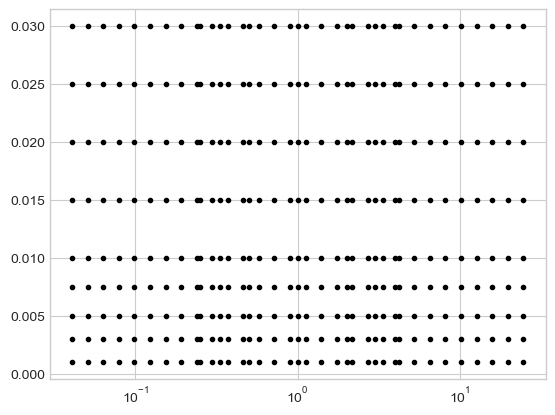

In [331]:
periods7 = np.logspace(np.log10(1/24.5), np.log10(24.5), 30)

extra_periods = (1/4, 1/3, 1/2, 1, 2, 3, 4)

periods7_append_sorted = np.sort(np.append(periods7, np.array(extra_periods)))

X7, Y7 = np.meshgrid(periods7_append_sorted, amplitudes6)

plt.plot(X7, Y7, 'k.')
plt.semilogx()

In [22]:
periods_denser_raw = np.logspace(np.log10(1/24.5), np.log10(24.5), 60)
extra_periods = (1/4, 1/3, 1/2, 1, 2, 3, 4)
periods_denser = np.sort(np.append(periods_denser_raw, np.array(extra_periods)))

amplitudes_denser = [0.001, 0.003, 0.005, 0.0075, 0.0085, 0.01, 0.0125, 0.015, 0.02, 0.025, 0.03]

In [23]:
print(periods_denser)

[ 0.04081633  0.04549088  0.05070078  0.05650736  0.06297895  0.07019171
  0.07823051  0.08718997  0.09717553  0.1083047   0.12070845  0.13453276
  0.14994032  0.16711245  0.18625124  0.20758193  0.23135555  0.25
  0.25785188  0.28738274  0.32029566  0.33333333  0.35697798  0.3978614
  0.44342705  0.49421117  0.5         0.55081142  0.61389389  0.68420097
  0.76256007  0.84989336  0.94722862  1.          1.05571134  1.1766182
  1.3113721   1.46155888  1.62894601  1.8155034   2.          2.02342654
  2.25516238  2.5134381   2.80129322  3.          3.12211536  3.47968011
  3.87819549  4.          4.32235141  4.81737493  5.36909173  5.98399469
  6.6693203   7.43313381  8.28442417  9.23320978 10.29065642 11.46920867
 12.7827363  14.24669759 15.87832114 17.69680874 19.72356124 21.98243049
 24.5       ]


In [24]:
startTime = datetime.now()
print(f"Starting at: {startTime}")

output_denser = recovery_score(dat, sids, periods_denser, amplitudes_denser)

print(f"elapsed time: ", datetime.now() - startTime)


Starting at: 2021-08-18 22:49:42.535301
A=0.00 mag. Incorrect period: 0.07 v. 0.04
A=0.00 mag. Incorrect period: 1.01 v. 0.04
A=0.00 mag. Incorrect period: 100.00 v. 0.04
A=0.00 mag. Incorrect period: 0.52 v. 0.04
A=0.00 mag. Incorrect period: 0.06 v. 0.04
A=0.00 mag. Incorrect period: 0.05 v. 0.04
A=0.00 mag. Incorrect period: 0.05 v. 0.04
A=0.00 mag. Incorrect period: 1.01 v. 0.04
A=0.00 mag. Incorrect period: 0.14 v. 0.04
A=0.00 mag. Incorrect period: 0.08 v. 0.04
A=0.00 mag. Incorrect period: 0.06 v. 0.04
A=0.00 mag. Incorrect period: 0.05 v. 0.04
A=0.00 mag. Incorrect period: 0.98 v. 0.04
A=0.00 mag. Incorrect period: 0.05 v. 0.04
A=0.00 mag. Incorrect period: 1.00 v. 0.04
A=0.00 mag. Incorrect period: 1.01 v. 0.04
A=0.00 mag. Incorrect period: 1.24 v. 0.04
A=0.00 mag. Incorrect period: 0.04 v. 0.04
A=0.00 mag. Incorrect period: 0.45 v. 0.04
A=0.00 mag. Incorrect period: 0.07 v. 0.04
A=0.00 mag. Incorrect period: 93.46 v. 0.04
A=0.00 mag. Incorrect period: 1.00 v. 0.04
A=0.00 mag.

A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 0.06 v. 0.04
A=0.01 mag. Incorrect period: 6.15 v. 0.04
A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 0.99 v. 0.04
A=0.01 mag. Incorrect period: 0.05 v. 0.04
A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 1.01 v. 0.04
A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 0.06 v. 0.04
A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 0.05 v. 0.04
A=0.01 mag. Incorrect period: 97.09 v. 0.04
A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 0.08 v. 0.04
A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 0.04 v. 0.04
A=0.01 mag. Incorrect period: 2.59 v. 0.04
A=0.01 mag

A=0.03 mag. Incorrect period: 0.14 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.99 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag. Incorrect period: 0.04 v. 0.04
A=0.03 mag.

A=0.01 mag. Incorrect period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.04 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 1.01 v. 0.05
A=0.01 mag. Incorrect period: 1.24 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.11 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 1.00 v. 0.05
A=0.01 mag. Incorrect period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.04 v. 0.05
A=0.01 mag. Incorrect period: 1.01 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.08 v. 0.05
A=0.01 mag. Incorrect period: 79.36 v. 0.05
A=0.01 mag. Incorrect period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 6.16 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 1.03 v. 0.05
A=0.01 mag. Incorrect 

A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Incorrect period: 0.04 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Incorrect period: 0.05 v. 0.05
A=0.02 mag. Incorrect period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Incorrect period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 m

A=0.01 mag. Incorrect period: 0.52 v. 0.05
A=0.01 mag. Incorrect period: 0.06 v. 0.05
A=0.01 mag. Incorrect period: 0.07 v. 0.05
A=0.01 mag. Incorrect period: 0.55 v. 0.05
A=0.01 mag. Incorrect period: 1.01 v. 0.05
A=0.01 mag. Incorrect period: 0.14 v. 0.05
A=0.01 mag. Incorrect period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.06 v. 0.05
A=0.01 mag. Incorrect period: 0.07 v. 0.05
A=0.01 mag. Incorrect period: 41.32 v. 0.05
A=0.01 mag. Incorrect period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.06 v. 0.05
A=0.01 mag. Incorrect period: 1.01 v. 0.05
A=0.01 mag. Incorrect period: 1.24 v. 0.05
A=0.01 mag. Incorrect period: 0.10 v. 0.05
A=0.01 mag. Incorrect period: 0.45 v. 0.05
A=0.01 mag. Incorrect period: 0.07 v. 0.05
A=0.01 mag. Incorrect period: 92.59 v. 0.05
A=0.01 mag. Incorrect period: 1.00 v. 0.05
A=0.01 mag. Incorrect period: 1.00 v. 0.05
A=0.01 mag. Incorrect period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 1.01 v. 0.05
A=0.01 mag. Incorrect period: 0.06 v. 0.05
A=0.01 ma

A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.06 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.05 v. 0.05
A=0.01 mag

A=0.00 mag. Incorrect period: 98.04 v. 0.06
A=0.00 mag. Incorrect period: 0.08 v. 0.06
A=0.00 mag. Incorrect period: 1.00 v. 0.06
A=0.00 mag. Incorrect period: 0.04 v. 0.06
A=0.00 mag. Incorrect period: 0.17 v. 0.06
A=0.00 mag. Incorrect period: 0.07 v. 0.06
A=0.00 mag. Incorrect period: 1.01 v. 0.06
A=0.00 mag. Incorrect period: 100.00 v. 0.06
A=0.00 mag. Incorrect period: 0.52 v. 0.06
A=0.00 mag. Correct period: 0.06 v. 0.06
A=0.00 mag. Incorrect period: 0.06 v. 0.06
A=0.00 mag. Incorrect period: 0.05 v. 0.06
A=0.00 mag. Incorrect period: 1.01 v. 0.06
A=0.00 mag. Incorrect period: 0.14 v. 0.06
A=0.00 mag. Incorrect period: 0.15 v. 0.06
A=0.00 mag. Incorrect period: 0.34 v. 0.06
A=0.00 mag. Incorrect period: 0.05 v. 0.06
A=0.00 mag. Incorrect period: 0.04 v. 0.06
A=0.00 mag. Incorrect period: 0.05 v. 0.06
A=0.00 mag. Incorrect period: 1.00 v. 0.06
A=0.00 mag. Incorrect period: 1.01 v. 0.06
A=0.00 mag. Incorrect period: 1.24 v. 0.06
A=0.00 mag. Incorrect period: 0.04 v. 0.06
A=0.00 mag

A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 3.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 98.04 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 0.05 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 1.82 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.0

A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Incorrect period: 1.01 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.00 mag. Incorrect period: 0.06 v. 0.06
A=0.00 mag. Incorrect period: 1.01 v. 0.06
A=0.00 mag. Incorrect period: 1.01 v. 0.06
A=0.00 mag. Incorrect period: 0.52 v. 0.06
A=0.00 mag. Incorrect period: 0.06 v. 0.06
A=0.00 mag. Incorrect period: 0.06 v. 0.06
A=0.00 mag. Incorrect period: 0.05 v. 0.06
A=0.00 mag. Incorrect period: 1.01 v. 0.06
A=0.00 mag. Incorrect period: 0.14 v. 0.06
A=0.00 mag. Incorrect period: 0.08 v. 0.06
A=0.00 mag. Incorrect period: 0.06 

A=0.01 mag. Incorrect period: 41.32 v. 0.06
A=0.01 mag. Incorrect period: 1.00 v. 0.06
A=0.01 mag. Incorrect period: 0.07 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 0.20 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 0.07 v. 0.06
A=0.01 mag. Incorrect period: 0.07 v. 0.06
A=0.01 mag. Incorrect period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 0.09 v. 0.06
A=0.01 mag. Incorrect period: 0.05 v. 0.06
A=0.01 mag. Incorrect period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 1.19 v. 0.06
A=0.01 mag. Incorrect period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 1.00 v. 0.06
A=0.01 mag. Incorrect period: 99.01 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 1.01 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct perio

A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Incorrect period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Incorrect period: 100.00 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag

A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Incorrect period: 0.11 v. 0.07
A=0.01 mag. Incorrect period: 5.05 v. 0.07
A=0.01 mag. Incorrect period: 0.08 v. 0.07
A=0.01 mag. Incorrect period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Incorrect period: 0.20 v. 0.07
A=0.01 mag. Incorrect period: 1.00 v. 0.07
A=0.01 mag. Incorrect period: 0.05 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Incorrect period: 0.06 v. 0.07
A=0.01 mag. Incorrect period: 0.25 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Incorrect period: 0.06 v. 0.07
A=0.01 mag. Incorrect period: 0.08 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Incorrect period: 3.06 v. 0.07
A=0.01 mag. Incorrect period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.0

A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Incorrect period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Incorrect period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. Correct period: 0.07 v. 0.07
A=0.02 mag. 

A=0.01 mag. Incorrect period: 0.52 v. 0.08
A=0.01 mag. Incorrect period: 0.06 v. 0.08
A=0.01 mag. Incorrect period: 0.05 v. 0.08
A=0.01 mag. Incorrect period: 0.09 v. 0.08
A=0.01 mag. Incorrect period: 1.01 v. 0.08
A=0.01 mag. Incorrect period: 0.08 v. 0.08
A=0.01 mag. Incorrect period: 0.04 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Incorrect period: 1.53 v. 0.08
A=0.01 mag. Incorrect period: 0.08 v. 0.08
A=0.01 mag. Incorrect period: 0.05 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Incorrect period: 1.01 v. 0.08
A=0.01 mag. Incorrect period: 1.24 v. 0.08
A=0.01 mag. Incorrect period: 0.04 v. 0.08
A=0.01 mag. Incorrect period: 0.05 v. 0.08
A=0.01 mag. Incorrect period: 0.15 v. 0.08
A=0.01 mag. Incorrect period: 92.59 v. 0.08
A=0.01 mag. Incorrect period: 1.00 v. 0.08
A=0.01 mag. Incorrect period: 0.05 v. 0.08
A=0.01 mag. Incorrect period: 0.17 v. 0.08
A=0.01 mag. Incorrect period: 1.01 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Inco

A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Incorrect period: 0.06 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Incorrect period: 5.04 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Incorrect period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Incorrect period: 1.00 v. 0.08
A=0.01 m

A=0.00 mag. Incorrect period: 0.08 v. 0.09
A=0.00 mag. Incorrect period: 1.00 v. 0.09
A=0.00 mag. Incorrect period: 0.04 v. 0.09
A=0.00 mag. Incorrect period: 0.17 v. 0.09
A=0.00 mag. Incorrect period: 0.07 v. 0.09
A=0.00 mag. Incorrect period: 73.53 v. 0.09
A=0.00 mag. Incorrect period: 1.00 v. 0.09
A=0.00 mag. Incorrect period: 0.52 v. 0.09
A=0.00 mag. Incorrect period: 0.06 v. 0.09
A=0.00 mag. Incorrect period: 0.06 v. 0.09
A=0.00 mag. Incorrect period: 0.05 v. 0.09
A=0.00 mag. Incorrect period: 1.00 v. 0.09
A=0.00 mag. Incorrect period: 0.05 v. 0.09
A=0.00 mag. Incorrect period: 0.08 v. 0.09
A=0.00 mag. Incorrect period: 0.05 v. 0.09
A=0.00 mag. Incorrect period: 0.04 v. 0.09
A=0.00 mag. Incorrect period: 0.98 v. 0.09
A=0.00 mag. Incorrect period: 0.05 v. 0.09
A=0.00 mag. Incorrect period: 1.00 v. 0.09
A=0.00 mag. Incorrect period: 1.01 v. 0.09
A=0.00 mag. Incorrect period: 1.24 v. 0.09
A=0.00 mag. Incorrect period: 0.04 v. 0.09
A=0.00 mag. Incorrect period: 0.45 v. 0.09
A=0.00 mag

A=0.01 mag. Incorrect period: 0.08 v. 0.09
A=0.01 mag. Incorrect period: 0.10 v. 0.09
A=0.01 mag. Incorrect period: 0.10 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Incorrect period: 97.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Incorrect period: 0.06 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Incorrect period: 0.10 v. 0.09
A=0.01 mag. Incorrect period: 0.08 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A

A=0.03 mag. Correct period: 0.09 v. 0.09
A=0.03 mag. Correct period: 0.09 v. 0.09
A=0.03 mag. Correct period: 0.09 v. 0.09
A=0.03 mag. Correct period: 0.09 v. 0.09
A=0.03 mag. Correct period: 0.09 v. 0.09
A=0.03 mag. Correct period: 0.09 v. 0.09
A=0.03 mag. Correct period: 0.09 v. 0.09
A=0.03 mag. Correct period: 0.09 v. 0.09
A=0.03 mag. Incorrect period: 96.15 v. 0.09
A=0.03 mag. Correct period: 0.09 v. 0.09
A=0.03 mag. Correct period: 0.09 v. 0.09
A=0.03 mag. Correct period: 0.09 v. 0.09
A=0.03 mag. Correct period: 0.09 v. 0.09
A=0.00 mag. Incorrect period: 0.07 v. 0.10
A=0.00 mag. Incorrect period: 1.01 v. 0.10
A=0.00 mag. Incorrect period: 1.01 v. 0.10
A=0.00 mag. Incorrect period: 0.52 v. 0.10
A=0.00 mag. Incorrect period: 0.06 v. 0.10
A=0.00 mag. Incorrect period: 0.05 v. 0.10
A=0.00 mag. Incorrect period: 0.05 v. 0.10
A=0.00 mag. Incorrect period: 1.01 v. 0.10
A=0.00 mag. Incorrect period: 0.14 v. 0.10
A=0.00 mag. Incorrect period: 0.08 v. 0.10
A=0.00 mag. Incorrect period: 0.06

A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Incorrect period: 1.01 v. 0.10
A=0.01 mag. Incorrect period: 1.00 v. 0.10
A=0.01 mag. Incorrect period: 1.00 v. 0.10
A=0.01 mag. Incorrect period: 0.08 v. 0.10
A=0.01 mag. Incorrect period: 0.05 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Incorrect period: 0.06 v. 0.10
A=0.01 mag. Incorrect period: 0.09 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Incorrect period: 0.09 v. 0.10
A=0.01 mag. Incorrect period: 0.08 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Incorrect period: 1.19 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Incorrect period: 98.04 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Incorrect period: 74.63 v. 0.10
A=0.01 mag. Correct period: 0.1

A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Incorrect period: 0.09 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Incorrect period: 0.09 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Incorrect period: 0.99 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag

A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Incorrect period: 0.10 v. 0.11
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Incorrect period: 0.06 v. 0.11
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Incorrect period: 1.01 v. 0.11
A=0.01 mag. Incorrect period: 5.05 v. 0.11
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Incorrect period: 0.12 v. 0.11
A=0.01 mag. Incorrect period: 0.09 v. 0.11
A=0.01 mag. Incorrect period: 0.20 v. 0.11
A=0.01 mag. Incorrect period: 1.00 v. 0.11
A=0.01 mag. Incorrect period: 1.00 v. 0.11
A=0.01 mag. Incorrect period: 0.11 v. 0.11
A=0.01 mag. Incorrect period: 0.06 v. 0.11
A=0.01 mag. Incorrect period: 0.10 v. 0.11
A=0.01 mag. Incorrect period: 0.14 v. 0.11
A=0.01 mag. Incorrect period: 0.12 v. 0.11
A=0.01 mag. Incorrect period: 0.16 v. 0.11
A=0.01 mag. Incorrect period: 0.18 v. 0.11
A=0.01 mag. Incorrect period: 0.12 v. 0.11
A=0.01 mag. Incorrect period: 0.12 v. 0.11
A=0.01 mag. Incorrect period: 6.16 v. 0.11
A=0.01 mag. Incorre

A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Incorrect period: 0.12 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Incorrect period: 0.12 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Incorrect period: 0.12 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Incorrect period: 1.00 v. 0.11
A=0.02 mag. Incorrect period: 0.12 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Incorrect period: 0.12 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Incorrect period: 0.12 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=

A=0.01 mag. Incorrect period: 0.05 v. 0.12
A=0.01 mag. Incorrect period: 1.01 v. 0.12
A=0.01 mag. Incorrect period: 1.01 v. 0.12
A=0.01 mag. Incorrect period: 0.52 v. 0.12
A=0.01 mag. Incorrect period: 0.06 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Incorrect period: 0.05 v. 0.12
A=0.01 mag. Incorrect period: 1.01 v. 0.12
A=0.01 mag. Incorrect period: 0.16 v. 0.12
A=0.01 mag. Incorrect period: 0.06 v. 0.12
A=0.01 mag. Incorrect period: 0.06 v. 0.12
A=0.01 mag. Incorrect period: 0.04 v. 0.12
A=0.01 mag. Incorrect period: 0.05 v. 0.12
A=0.01 mag. Incorrect period: 0.05 v. 0.12
A=0.01 mag. Incorrect period: 0.11 v. 0.12
A=0.01 mag. Incorrect period: 1.01 v. 0.12
A=0.01 mag. Incorrect period: 1.24 v. 0.12
A=0.01 mag. Incorrect period: 0.05 v. 0.12
A=0.01 mag. Incorrect period: 0.05 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Incorrect period: 92.59 v. 0.12
A=0.01 mag. Incorrect period: 1.00 v. 0.12
A=0.01 mag. Incorrect period: 1.00 v. 0.12
A=0.01 mag. In

A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Incorrect period: 1.00 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Incorrect period: 0.11 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Incorrect period: 0.06 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Incorrect period: 0.11 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Incorrect period: 1.24 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01

A=0.00 mag. Incorrect period: 6.15 v. 0.13
A=0.00 mag. Incorrect period: 0.07 v. 0.13
A=0.00 mag. Incorrect period: 1.00 v. 0.13
A=0.00 mag. Incorrect period: 98.04 v. 0.13
A=0.00 mag. Incorrect period: 1.01 v. 0.13
A=0.00 mag. Incorrect period: 1.00 v. 0.13
A=0.00 mag. Incorrect period: 0.04 v. 0.13
A=0.00 mag. Incorrect period: 0.10 v. 0.13
A=0.00 mag. Incorrect period: 0.07 v. 0.13
A=0.00 mag. Incorrect period: 1.01 v. 0.13
A=0.00 mag. Incorrect period: 100.00 v. 0.13
A=0.00 mag. Incorrect period: 0.52 v. 0.13
A=0.00 mag. Incorrect period: 0.06 v. 0.13
A=0.00 mag. Incorrect period: 0.05 v. 0.13
A=0.00 mag. Incorrect period: 0.05 v. 0.13
A=0.00 mag. Incorrect period: 1.01 v. 0.13
A=0.00 mag. Incorrect period: 0.07 v. 0.13
A=0.00 mag. Incorrect period: 0.08 v. 0.13
A=0.00 mag. Incorrect period: 0.06 v. 0.13
A=0.00 mag. Incorrect period: 0.11 v. 0.13
A=0.00 mag. Incorrect period: 0.04 v. 0.13
A=0.00 mag. Incorrect period: 0.05 v. 0.13
A=0.00 mag. Incorrect period: 1.00 v. 0.13
A=0.00 m

A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 0.13 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 6.14 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 1.00 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 0.05 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 1.01 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 0.12 v. 0.13
A=0.01 mag. Incorrect period: 0.06 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 0.07 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13


A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Incorrect period: 0.16 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Incorrect period: 1.00 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.03 mag. Correct period: 0.13 v. 0.13
A=0.00 mag. Incorrect period: 0.07 v. 0.15
A=0.00 mag. Incorrect period: 1.01 v. 0.15
A=0.00 mag. Incorrect period: 100.00 v. 0.15
A=0.00 mag. Incorrect period: 0.52 v. 0.15
A=0.00 mag. Incorrect period: 0.06 v. 0.15
A=0.00 mag. Incorrect period: 0.05 v. 0.15
A=0.00 mag. Incorrect period: 0.05 v. 0

A=0.01 mag. Incorrect period: 1.01 v. 0.15
A=0.01 mag. Incorrect period: 5.05 v. 0.15
A=0.01 mag. Incorrect period: 0.18 v. 0.15
A=0.01 mag. Incorrect period: 0.18 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Incorrect period: 94.34 v. 0.15
A=0.01 mag. Incorrect period: 1.00 v. 0.15
A=0.01 mag. Incorrect period: 1.00 v. 0.15
A=0.01 mag. Incorrect period: 0.06 v. 0.15
A=0.01 mag. Incorrect period: 77.52 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Incorrect period: 0.20 v. 0.15
A=0.01 mag. Incorrect period: 0.18 v. 0.15
A=0.01 mag. Incorrect period: 0.13 v. 0.15
A=0.01 mag. Incorrect period: 0.06 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Incorrect period: 0.18 v. 0.15
A=0.01 mag. Incorrect period: 1.19 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Incorrect period: 0.99 v. 0.15
A=0.01 mag. Incorrect period: 0.18 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct p

A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Incorrect period: 0.18 v. 0.15
A=0.03 mag. Incorrect period: 1.00 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Incorrect period: 0.18 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Incorrect period: 0.18 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 m

A=0.01 mag. Correct period: 0.17 v. 0.17
A=0.01 mag. Incorrect period: 0.05 v. 0.17
A=0.01 mag. Incorrect period: 1.01 v. 0.17
A=0.01 mag. Correct period: 0.17 v. 0.17
A=0.01 mag. Incorrect period: 0.27 v. 0.17
A=0.01 mag. Incorrect period: 0.12 v. 0.17
A=0.01 mag. Incorrect period: 0.04 v. 0.17
A=0.01 mag. Correct period: 0.17 v. 0.17
A=0.01 mag. Incorrect period: 0.07 v. 0.17
A=0.01 mag. Correct period: 0.17 v. 0.17
A=0.01 mag. Incorrect period: 1.01 v. 0.17
A=0.01 mag. Incorrect period: 1.24 v. 0.17
A=0.01 mag. Correct period: 0.17 v. 0.17
A=0.01 mag. Incorrect period: 0.45 v. 0.17
A=0.01 mag. Correct period: 0.17 v. 0.17
A=0.01 mag. Incorrect period: 1.01 v. 0.17
A=0.01 mag. Incorrect period: 1.00 v. 0.17
A=0.01 mag. Incorrect period: 1.00 v. 0.17
A=0.01 mag. Incorrect period: 0.05 v. 0.17
A=0.01 mag. Incorrect period: 0.11 v. 0.17
A=0.01 mag. Incorrect period: 0.14 v. 0.17
A=0.01 mag. Incorrect period: 0.08 v. 0.17
A=0.01 mag. Incorrect period: 1.01 v. 0.17
A=0.01 mag. Correct per

A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Incorrect period: 0.14 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Incorrect period: 0.14 v. 0.17
A=0.02 mag. Incorrect period: 0.13 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag

A=0.00 mag. Incorrect period: 0.05 v. 0.19
A=0.00 mag. Incorrect period: 0.04 v. 0.19
A=0.00 mag. Incorrect period: 0.15 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Incorrect period: 1.01 v. 0.19
A=0.01 mag. Incorrect period: 100.00 v. 0.19
A=0.01 mag. Incorrect period: 0.52 v. 0.19
A=0.01 mag. Incorrect period: 0.06 v. 0.19
A=0.01 mag. Incorrect period: 0.16 v. 0.19
A=0.01 mag. Incorrect period: 0.05 v. 0.19
A=0.01 mag. Incorrect period: 1.01 v. 0.19
A=0.01 mag. Incorrect period: 0.16 v. 0.19
A=0.01 mag. Incorrect period: 0.08 v. 0.19
A=0.01 mag. Incorrect period: 0.06 v. 0.19
A=0.01 mag. Incorrect period: 0.30 v. 0.19
A=0.01 mag. Incorrect period: 0.05 v. 0.19
A=0.01 mag. Incorrect period: 0.05 v. 0.19
A=0.01 mag. Incorrect period: 1.00 v. 0.19
A=0.01 mag. Incorrect period: 1.01 v. 0.19
A=0.01 mag. Incorrect period: 1.24 v. 0.19
A=0.01 mag. Incorrect period: 0.04 v. 0.19
A=0.01 mag. Incorrect period: 0.19 v. 0.19
A=0.01 mag. Incorrect period: 0.23 v. 0.19
A=0.01 mag.

A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Incorrect period: 1.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Incorrect period: 97.09 v. 0.19
A=0.01 mag. Incorrect period: 0.16 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Incorrect period: 0.16 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Incorrect period: 0.06 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Incorrect period: 0.16 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0

A=0.00 mag. Incorrect period: 0.08 v. 0.21
A=0.00 mag. Incorrect period: 0.09 v. 0.21
A=0.00 mag. Incorrect period: 0.25 v. 0.21
A=0.00 mag. Incorrect period: 0.24 v. 0.21
A=0.00 mag. Incorrect period: 6.16 v. 0.21
A=0.00 mag. Incorrect period: 0.07 v. 0.21
A=0.00 mag. Incorrect period: 1.00 v. 0.21
A=0.00 mag. Incorrect period: 98.04 v. 0.21
A=0.00 mag. Incorrect period: 1.01 v. 0.21
A=0.00 mag. Incorrect period: 0.05 v. 0.21
A=0.00 mag. Incorrect period: 0.04 v. 0.21
A=0.00 mag. Incorrect period: 0.17 v. 0.21
A=0.00 mag. Incorrect period: 0.05 v. 0.21
A=0.00 mag. Incorrect period: 1.01 v. 0.21
A=0.00 mag. Incorrect period: 1.01 v. 0.21
A=0.00 mag. Incorrect period: 0.52 v. 0.21
A=0.00 mag. Incorrect period: 0.06 v. 0.21
A=0.00 mag. Incorrect period: 0.07 v. 0.21
A=0.00 mag. Incorrect period: 0.55 v. 0.21
A=0.00 mag. Incorrect period: 1.01 v. 0.21
A=0.00 mag. Incorrect period: 0.08 v. 0.21
A=0.00 mag. Incorrect period: 0.05 v. 0.21
A=0.00 mag. Incorrect period: 0.06 v. 0.21
A=0.00 mag

A=0.01 mag. Incorrect period: 1.00 v. 0.21
A=0.01 mag. Incorrect period: 0.26 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Incorrect period: 0.17 v. 0.21
A=0.01 mag. Incorrect period: 0.17 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Incorrect period: 0.17 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Incorrect period: 99.01 v. 0.21
A=0.01 mag. Incorrect period: 0.26 v. 0.21
A=0.01 mag. Incorrect period: 0.17 v. 0.21
A=0.01 mag. Incorrect period: 0.26 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Incorrect period: 0.26 v. 0.21
A=0.01 mag. Incorrect period: 0.06 v

A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Incorrect period: 0.26 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Incorrect period: 0.99 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.03 mag. Correct period: 0.21 v. 0.21
A=0.00 mag. Incorrect period: 0.06 v. 0.23
A=0.00 mag. Incorrect period: 1.01 v. 0.23
A=0.00 mag. Incorrect period: 100.00 v. 0.23
A=0.

A=0.01 mag. Incorrect period: 0.30 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Incorrect period: 0.19 v. 0.23
A=0.01 mag. Incorrect period: 1.01 v. 0.23
A=0.01 mag. Incorrect period: 1.24 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Incorrect period: 97.09 v. 0.23
A=0.01 mag. Incorrect period: 1.00 v. 0.23
A=0.01 mag. Incorrect period: 0.11 v. 0.23
A=0.01 mag. Incorrect period: 0.05 v. 0.23
A=0.01 mag. Incorrect period: 0.26 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Incorrect period: 0.20 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Incorrect period: 0.21 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Incorrect period: 6.15 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Incorrect period: 1.

A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Incorrect period: 0.43 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Incorrect period: 0.30 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Incorrect period: 0.30 v. 0.23
A=0.03 mag

A=0.01 mag. Incorrect period: 1.01 v. 0.25
A=0.01 mag. Incorrect period: 0.06 v. 0.25
A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Incorrect period: 83.33 v. 0.25
A=0.01 mag. Incorrect period: 0.05 v. 0.25
A=0.01 mag. Incorrect period: 0.33 v. 0.25
A=0.01 mag. Incorrect period: 0.04 v. 0.25
A=0.01 mag. Incorrect period: 0.06 v. 0.25
A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Incorrect period: 0.20 v. 0.25
A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Incorrect period: 0.20 v. 0.25
A=0.01 mag. Incorrect period: 0.05 v. 0.25
A=0.01 mag. Incorrect period: 1.24 v. 0.25
A=0.01 mag. Incorrect period: 0.33 v. 0.25
A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Incorrect period: 0.20 v. 0.25
A=0.01 mag. Incorrect period: 0.99 v. 0.25
A=0.01 mag. Incorrect period: 1.00 v. 0.25
A=0.01 mag. Incorrect period: 0.17 v. 0.25
A=0.01 mag. Incorrect period: 0.33 v. 0.25
A=0.01 mag. Incorrect period: 0.21 v. 0.25
A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Incorrec

A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Incorrect period: 0.33 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Incorrect period: 0.20 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Incorrect period: 0.06 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Incorrect period: 0.20 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Incorrect period: 0.20 v. 0.25
A=0.02 mag. Incorrect period: 0.33 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.

A=0.00 mag. Incorrect period: 6.16 v. 0.26
A=0.00 mag. Incorrect period: 0.07 v. 0.26
A=0.00 mag. Incorrect period: 0.20 v. 0.26
A=0.00 mag. Incorrect period: 98.04 v. 0.26
A=0.00 mag. Incorrect period: 0.52 v. 0.26
A=0.00 mag. Incorrect period: 0.15 v. 0.26
A=0.00 mag. Incorrect period: 0.04 v. 0.26
A=0.00 mag. Incorrect period: 0.17 v. 0.26
A=0.01 mag. Incorrect period: 0.20 v. 0.26
A=0.01 mag. Incorrect period: 1.01 v. 0.26
A=0.01 mag. Incorrect period: 100.00 v. 0.26
A=0.01 mag. Incorrect period: 0.52 v. 0.26
A=0.01 mag. Incorrect period: 0.06 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Incorrect period: 0.05 v. 0.26
A=0.01 mag. Incorrect period: 1.01 v. 0.26
A=0.01 mag. Incorrect period: 0.20 v. 0.26
A=0.01 mag. Incorrect period: 0.21 v. 0.26
A=0.01 mag. Incorrect period: 0.13 v. 0.26
A=0.01 mag. Incorrect period: 0.05 v. 0.26
A=0.01 mag. Incorrect period: 0.89 v. 0.26
A=0.01 mag. Incorrect period: 0.17 v. 0.26
A=0.01 mag. Incorrect period: 0.11 v. 0.26
A=0.01 mag

A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Incorrect period: 6.17 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Incorrect period: 98.04 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Incorrect period: 0.06 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Incorrect period: 0.04 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Incorrect period: 0.35 v. 0.26
A=0.0

A=0.00 mag. Incorrect period: 1.01 v. 0.29
A=0.00 mag. Incorrect period: 0.05 v. 0.29
A=0.00 mag. Incorrect period: 0.20 v. 0.29
A=0.00 mag. Incorrect period: 0.50 v. 0.29
A=0.00 mag. Incorrect period: 0.08 v. 0.29
A=0.00 mag. Incorrect period: 0.09 v. 0.29
A=0.00 mag. Incorrect period: 0.25 v. 0.29
A=0.00 mag. Incorrect period: 0.24 v. 0.29
A=0.00 mag. Incorrect period: 6.16 v. 0.29
A=0.00 mag. Incorrect period: 0.07 v. 0.29
A=0.00 mag. Incorrect period: 1.00 v. 0.29
A=0.00 mag. Incorrect period: 98.04 v. 0.29
A=0.00 mag. Incorrect period: 1.01 v. 0.29
A=0.00 mag. Incorrect period: 0.18 v. 0.29
A=0.00 mag. Incorrect period: 0.04 v. 0.29
A=0.00 mag. Incorrect period: 0.17 v. 0.29
A=0.00 mag. Incorrect period: 0.22 v. 0.29
A=0.00 mag. Incorrect period: 1.01 v. 0.29
A=0.00 mag. Incorrect period: 100.00 v. 0.29
A=0.00 mag. Incorrect period: 0.52 v. 0.29
A=0.00 mag. Incorrect period: 0.06 v. 0.29
A=0.00 mag. Incorrect period: 0.06 v. 0.29
A=0.00 mag. Incorrect period: 0.05 v. 0.29
A=0.00 m

A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Incorrect period: 0.22 v. 0.29
A=0.01 mag. Incorrect period: 1.00 v. 0.29
A=0.01 mag. Incorrect period: 0.22 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Incorrect period: 0.15 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Incorrect period: 0.68 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Incorrect period: 6.17 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Incorrect period: 0.40 v. 0.29
A=0.01 mag. Incorrect period: 1.00 v. 0.29
A=0.01 mag. Incorrect period: 0.22 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.2

A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Incorrect period: 0.22 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Incorrect period: 1.00 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.00 mag. 

A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Incorrect period: 0.24 v. 0.32
A=0.01 mag. Incorrect period: 0.09 v. 0.32
A=0.01 mag. Incorrect period: 0.47 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Incorrect period: 0.04 v. 0.32
A=0.01 mag. Incorrect period: 1.24 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Incorrect period: 0.24 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Incorrect period: 0.10 v. 0.32
A=0.01 mag. Incorrect period: 1.00 v. 0.32
A=0.01 mag. Incorrect period: 0.12 v. 0.32
A=0.01 mag. Incorrect period: 0.04 v. 0.32
A=0.01 mag. Incorrect period: 0.21 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Incorrect period: 0.47 v. 0.32
A=0.01 mag. Incorrect period: 0.24 v. 0.32
A=0.01 mag. Incorrect period: 0.14 v. 0.32
A=0.01 mag. Incorrect period: 0.08 v. 0.32
A=0.01 mag. Incorrect period: 0.92 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Incorrect per

A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Incorrect period: 0.47 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Incorrect period: 0.24 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Incorrect period: 0.24 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag. Correct period: 0.32 v. 0.32
A=0.03 mag

A=0.01 mag. Incorrect period: 0.25 v. 0.33
A=0.01 mag. Incorrect period: 0.50 v. 0.33
A=0.01 mag. Incorrect period: 1.01 v. 0.33
A=0.01 mag. Incorrect period: 0.49 v. 0.33
A=0.01 mag. Incorrect period: 0.06 v. 0.33
A=0.01 mag. Incorrect period: 0.25 v. 0.33
A=0.01 mag. Incorrect period: 0.05 v. 0.33
A=0.01 mag. Incorrect period: 0.50 v. 0.33
A=0.01 mag. Incorrect period: 0.50 v. 0.33
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Incorrect period: 0.14 v. 0.33
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Incorrect period: 0.50 v. 0.33
A=0.01 mag. Incorrect period: 0.25 v. 0.33
A=0.01 mag. Incorrect period: 0.50 v. 0.33
A=0.01 mag. Incorrect period: 0.50 v. 0.33
A=0.01 mag. Incorrect period: 1.24 v. 0.33
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Incorrect period: 0.05 v. 0.33
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Incorrect period: 1.01 v. 0.33
A=0.01 mag. Incorrect period: 1.00 v. 0.33
A=0.01 mag. Incorrect period: 0.50 v. 0.33
A=0.01 mag. Incorre

A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Incorrect period: 1.00 v. 0.33
A=0.01 mag. Incorrect period: 0.50 v. 0.33
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Incorrect period: 0.25 v. 0.33
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Incorrect period: 0.10 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Incorrect period: 0.50 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Incorrect period: 0.25 v. 0.33
A=0.02 mag. Incorrect period: 0.50 v. 0.33
A=0.02 mag. Incorrect period: 0.25 v. 0.33
A=0.02 mag. Incorrect period: 0.50 v. 0.33
A=0.02 mag. Incorrect period: 0.50 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0

A=0.00 mag. Incorrect period: 0.25 v. 0.36
A=0.00 mag. Incorrect period: 0.11 v. 0.36
A=0.00 mag. Incorrect period: 6.16 v. 0.36
A=0.00 mag. Incorrect period: 0.07 v. 0.36
A=0.00 mag. Incorrect period: 1.00 v. 0.36
A=0.00 mag. Incorrect period: 1.00 v. 0.36
A=0.00 mag. Incorrect period: 1.01 v. 0.36
A=0.00 mag. Correct period: 0.36 v. 0.36
A=0.00 mag. Incorrect period: 0.12 v. 0.36
A=0.00 mag. Incorrect period: 0.05 v. 0.36
A=0.01 mag. Incorrect period: 0.07 v. 0.36
A=0.01 mag. Incorrect period: 1.01 v. 0.36
A=0.01 mag. Incorrect period: 100.00 v. 0.36
A=0.01 mag. Incorrect period: 0.52 v. 0.36
A=0.01 mag. Incorrect period: 0.06 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Incorrect period: 0.05 v. 0.36
A=0.01 mag. Incorrect period: 1.01 v. 0.36
A=0.01 mag. Incorrect period: 0.14 v. 0.36
A=0.01 mag. Incorrect period: 0.26 v. 0.36
A=0.01 mag. Incorrect period: 0.06 v. 0.36
A=0.01 mag. Incorrect period: 0.09 v. 0.36
A=0.01 mag. Incorrect period: 0.05 v. 0.36
A=0.01 mag. I

A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Incorrect period: 0.56 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Incorrect period: 0.26 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Incorrect period: 0.56 v. 0.36
A=0.01 mag. Incorrect period: 1.00 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Incorrect period: 0.06 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Incorrect period: 0.56 v. 0.36
A=0.

A=0.00 mag. Incorrect period: 1.00 v. 0.40
A=0.00 mag. Incorrect period: 1.00 v. 0.40
A=0.00 mag. Incorrect period: 0.17 v. 0.40
A=0.00 mag. Incorrect period: 1.01 v. 0.40
A=0.00 mag. Incorrect period: 0.05 v. 0.40
A=0.00 mag. Incorrect period: 0.20 v. 0.40
A=0.00 mag. Incorrect period: 0.50 v. 0.40
A=0.00 mag. Incorrect period: 0.08 v. 0.40
A=0.00 mag. Incorrect period: 0.09 v. 0.40
A=0.00 mag. Incorrect period: 1.00 v. 0.40
A=0.00 mag. Incorrect period: 0.24 v. 0.40
A=0.00 mag. Incorrect period: 6.15 v. 0.40
A=0.00 mag. Incorrect period: 0.07 v. 0.40
A=0.00 mag. Incorrect period: 1.00 v. 0.40
A=0.00 mag. Incorrect period: 98.04 v. 0.40
A=0.00 mag. Incorrect period: 0.08 v. 0.40
A=0.00 mag. Incorrect period: 1.00 v. 0.40
A=0.00 mag. Incorrect period: 0.04 v. 0.40
A=0.00 mag. Incorrect period: 0.09 v. 0.40
A=0.00 mag. Incorrect period: 0.05 v. 0.40
A=0.00 mag. Incorrect period: 1.01 v. 0.40
A=0.00 mag. Incorrect period: 1.01 v. 0.40
A=0.00 mag. Incorrect period: 0.52 v. 0.40
A=0.00 mag

A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Incorrect period: 0.22 v. 0.40
A=0.01 mag. Incorrect period: 1.24 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Incorrect period: 1.01 v. 0.40
A=0.01 mag. Incorrect period: 1.00 v. 0.40
A=0.01 mag. Incorrect period: 0.50 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Incorrect period: 0.05 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Incorrect period: 0.11 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Incorrect period: 0.28 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Incorrect period: 1.19 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Incorrect period: 98.04 v. 0.40
A=0.01 mag. Incorrect period: 0.08 v. 0.40
A=0.01 mag. Correct period: 0.40 v

A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Incorrect period: 0.66 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Incorrect period: 0.66 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Incorrect period: 99.01 v. 0.40
A=0.03 ma

A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Incorrect period: 0.09 v. 0.44
A=0.01 mag. Incorrect period: 0.07 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Incorrect period: 0.15 v. 0.44
A=0.01 mag. Incorrect period: 0.80 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Incorrect period: 0.31 v. 0.44
A=0.01 mag. Incorrect period: 0.05 v. 0.44
A=0.01 mag. Incorrect period: 1.24 v. 0.44
A=0.01 mag. Incorrect period: 0.80 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Incorrect period: 0.20 v. 0.44
A=0.01 mag. Incorrect period: 1.00 v. 0.44
A=0.01 mag. Incorrect period: 1.00 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Incorrect period: 77.52 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Incorrect period: 0.06 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Correct period: 0.

A=0.03 mag. Incorrect period: 0.80 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Incorrect period: 0.06 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Incorrect period: 0.80 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Correct period: 0.44 v. 0.44
A=0.03 mag. Incorrect period: 0.80 v. 0.44
A=0.03 m

A=0.01 mag. Incorrect period: 0.99 v. 0.49
A=0.01 mag. Incorrect period: 1.01 v. 0.49
A=0.01 mag. Incorrect period: 0.18 v. 0.49
A=0.01 mag. Incorrect period: 0.20 v. 0.49
A=0.01 mag. Incorrect period: 0.05 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Incorrect period: 0.99 v. 0.49
A=0.01 mag. Incorrect period: 0.33 v. 0.49
A=0.01 mag. Incorrect period: 0.52 v. 0.49
A=0.01 mag. Incorrect period: 0.06 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Incorrect period: 0.10 v. 0.49
A=0.01 mag. Incorrect period: 1.00 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Incorrect period: 0.08 v. 0.49
A=0.01 mag. Incorrect period: 0.33 v. 0.49
A=0.01 mag. Incorrect period: 0.33 v. 0.49
A=0.01 mag. Incorrect period: 0.33 v. 0.49
A=0.01 mag. Incorrect period: 0.98 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Incorrect period: 1.01 v. 0.49
A=0.01 mag. Incorrect period: 1.24 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Incorrect

A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Incorrect period: 0.33 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Incorrect period: 0.99 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.02 mag. Correct period: 0.49 v. 0.49
A=0.02 mag. Incorrect period: 0.33 v. 0.49
A=0.02 mag. Correct period: 0.49 v. 0.49
A=0.02 mag. Correct period: 0.49 v. 0.49
A=0.02 mag. Incorrect period: 0.06 v. 0.49
A=0.02 mag. Correct period: 0.49 v. 0.49
A=0.02 mag. Correct period: 0.49 v. 0.49
A=0.02 mag. Correct period: 0.49 v. 0.49
A=0.02 mag. Correct period: 0.49 v. 0.49
A=0.02 mag. Correct period: 0.49 v. 0.49
A=0.02 mag. Correct period: 0.49 v. 0.49
A=0.02 mag. Correct period: 0.49 v. 0.49
A=0.02 mag. Correct period: 0.49 v. 0.49
A=0.02 mag. Correct period: 0.49 v. 0.49
A=0.02 m

A=0.00 mag. Incorrect period: 0.13 v. 0.50
A=0.00 mag. Incorrect period: 1.00 v. 0.50
A=0.00 mag. Incorrect period: 0.21 v. 0.50
A=0.00 mag. Incorrect period: 1.00 v. 0.50
A=0.00 mag. Incorrect period: 1.00 v. 0.50
A=0.00 mag. Incorrect period: 1.00 v. 0.50
A=0.00 mag. Incorrect period: 6.15 v. 0.50
A=0.00 mag. Incorrect period: 1.01 v. 0.50
A=0.00 mag. Correct period: 0.50 v. 0.50
A=0.00 mag. Incorrect period: 99.01 v. 0.50
A=0.00 mag. Incorrect period: 0.08 v. 0.50
A=0.00 mag. Incorrect period: 1.00 v. 0.50
A=0.00 mag. Incorrect period: 0.33 v. 0.50
A=0.00 mag. Incorrect period: 0.10 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Incorrect period: 0.20 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Incorrect period: 0.34 v. 0.50
A=0.01 mag. Incorrect period: 0.06 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Incorrect period: 0.04 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Incorrect period: 0.10 v. 0.50
A=0.01 mag. 

A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Correct period: 0.50 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Correct period: 0.50 v. 0.50
A=0.01 mag. Incorrect period: 0.06 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Incorrect period: 0.13 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Correct period: 0.50 v. 0.50
A=0.01 mag. Correct period: 0.50 v. 0.50
A=0.01 mag. Correct period: 0.50 v. 0.50
A=0.01 mag. Incorrect period: 0.99 v. 0.50
A=0.01 mag. Incorrect period: 0.33 v. 0.50
A=0.01 mag. Correct period: 0.50 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Correct period: 0.50 v. 0.50
A=0.01 mag. Incorrect period: 1.00 v. 0.50
A=0.01 mag. Correct perio

A=0.00 mag. Incorrect period: 1.00 v. 0.55
A=0.00 mag. Incorrect period: 1.01 v. 0.55
A=0.00 mag. Incorrect period: 1.24 v. 0.55
A=0.00 mag. Incorrect period: 0.04 v. 0.55
A=0.00 mag. Incorrect period: 0.45 v. 0.55
A=0.00 mag. Incorrect period: 0.07 v. 0.55
A=0.00 mag. Incorrect period: 93.46 v. 0.55
A=0.00 mag. Incorrect period: 1.00 v. 0.55
A=0.00 mag. Incorrect period: 1.00 v. 0.55
A=0.00 mag. Incorrect period: 0.17 v. 0.55
A=0.00 mag. Incorrect period: 1.01 v. 0.55
A=0.00 mag. Incorrect period: 0.05 v. 0.55
A=0.00 mag. Incorrect period: 0.20 v. 0.55
A=0.00 mag. Incorrect period: 0.50 v. 0.55
A=0.00 mag. Incorrect period: 0.08 v. 0.55
A=0.00 mag. Incorrect period: 0.09 v. 0.55
A=0.00 mag. Incorrect period: 0.25 v. 0.55
A=0.00 mag. Incorrect period: 0.24 v. 0.55
A=0.00 mag. Incorrect period: 6.16 v. 0.55
A=0.00 mag. Incorrect period: 0.07 v. 0.55
A=0.00 mag. Incorrect period: 1.00 v. 0.55
A=0.00 mag. Incorrect period: 98.04 v. 0.55
A=0.00 mag. Incorrect period: 1.01 v. 0.55
A=0.00 ma

A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Incorrect period: 5.39 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Incorrect period: 0.35 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Incorrect period: 1.23 v. 0.55
A=0.01 mag. Incorrect period: 0.35 v. 0.55
A=0.01 mag. Incorrect period: 5.04 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Incorrect period: 1.00 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Incorrect period: 0.26 v. 0.55
A=0.01 mag. Incorrect period: 0.35 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Incorrect period: 0.14 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Incorrect period: 0.17 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Incorrect period: 0.35 v.

A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Incorrect period: 1.23 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Co

A=0.01 mag. Incorrect period: 0.09 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Incorrect period: 1.01 v. 0.61
A=0.01 mag. Incorrect period: 100.00 v. 0.61
A=0.01 mag. Incorrect period: 0.38 v. 0.61
A=0.01 mag. Incorrect period: 0.06 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Incorrect period: 0.05 v. 0.61
A=0.01 mag. Incorrect period: 1.00 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Incorrect period: 0.38 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Incorrect period: 1.60 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Incorrect period: 1.60 v. 0.61
A=0.01 mag. Incorrect period: 0.13 v. 0.61
A=0.01 mag. Incorrect period: 1.24 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Incorrect period: 1.60 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Incorrect period: 92.59 v. 0.61
A=0.01 mag. Incorrect peri

A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Incorrect period: 97.09 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Incorrect period: 0.06 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag. Correct period: 0.61 v. 0.61
A=0.03 mag.

A=0.01 mag. Incorrect period: 0.09 v. 0.68
A=0.01 mag. Incorrect period: 1.00 v. 0.68
A=0.01 mag. Incorrect period: 0.11 v. 0.68
A=0.01 mag. Incorrect period: 6.16 v. 0.68
A=0.01 mag. Incorrect period: 1.11 v. 0.68
A=0.01 mag. Incorrect period: 0.50 v. 0.68
A=0.01 mag. Incorrect period: 98.04 v. 0.68
A=0.01 mag. Incorrect period: 0.24 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Incorrect period: 0.04 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Incorrect period: 1.01 v. 0.68
A=0.01 mag. Incorrect period: 0.05 v. 0.68
A=0.01 mag. Incorrect period: 0.52 v. 0.68
A=0.01 mag. Incorrect period: 0.06 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Incorrect period: 0.15 v. 0.68
A=0.01 mag. Incorrect period: 1.01 v. 0.68
A=0.01 mag. Incorrect period: 0.41 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Incorrect period: 2.18 v. 0.68
A=0.01 mag. Incorrect 

A=0.01 mag. Incorrect period: 0.15 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Incorrect period: 0.20 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Incorrect period: 2.18 v. 0.68
A=0.01 mag. Incorrect period: 2.18 v. 0.68
A=0.01 mag. Incorrect period: 0.18 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Incorrect period: 98.04 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.02 mag. Correct period: 0.68 v. 0.68
A=0.02 mag. Correct period: 0.68 v. 0.68
A=0.02 mag. Correct period: 0.68 v. 0.68
A=0.02 mag. Correct period: 0.68 v. 0.68
A=0.02 mag. Incorrect period: 0.06 v. 0.68
A=0.02 mag. Correct period: 0.68 v. 0.68
A=0.02 mag. Correct period: 0.68 v. 0.68
A=0.02 mag. Correct period: 0.68 v. 0.68
A

A=0.00 mag. Incorrect period: 93.46 v. 0.76
A=0.00 mag. Incorrect period: 1.00 v. 0.76
A=0.00 mag. Incorrect period: 1.00 v. 0.76
A=0.00 mag. Incorrect period: 0.17 v. 0.76
A=0.00 mag. Incorrect period: 1.01 v. 0.76
A=0.00 mag. Incorrect period: 0.06 v. 0.76
A=0.00 mag. Incorrect period: 0.20 v. 0.76
A=0.00 mag. Incorrect period: 0.12 v. 0.76
A=0.00 mag. Incorrect period: 0.09 v. 0.76
A=0.00 mag. Incorrect period: 0.09 v. 0.76
A=0.00 mag. Incorrect period: 1.00 v. 0.76
A=0.00 mag. Incorrect period: 0.24 v. 0.76
A=0.00 mag. Incorrect period: 6.15 v. 0.76
A=0.00 mag. Incorrect period: 0.07 v. 0.76
A=0.00 mag. Incorrect period: 1.00 v. 0.76
A=0.00 mag. Incorrect period: 98.04 v. 0.76
A=0.00 mag. Incorrect period: 0.08 v. 0.76
A=0.00 mag. Incorrect period: 0.43 v. 0.76
A=0.00 mag. Incorrect period: 0.04 v. 0.76
A=0.00 mag. Incorrect period: 0.43 v. 0.76
A=0.01 mag. Incorrect period: 0.06 v. 0.76
A=0.01 mag. Incorrect period: 1.01 v. 0.76
A=0.01 mag. Incorrect period: 100.00 v. 0.76
A=0.01 

A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Incorrect period: 3.24 v. 0.76
A=0.01 mag. Incorrect period: 5.04 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Incorrect period: 0.20 v. 0.76
A=0.01 mag. Incorrect period: 1.00 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Incorrect period: 0.05 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Incorrect period: 0.25 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Incorrect period: 6.15 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Incorrect period: 0.99 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76


A=0.00 mag. Incorrect period: 0.98 v. 0.85
A=0.00 mag. Incorrect period: 0.05 v. 0.85
A=0.00 mag. Incorrect period: 1.00 v. 0.85
A=0.00 mag. Incorrect period: 1.01 v. 0.85
A=0.00 mag. Incorrect period: 1.24 v. 0.85
A=0.00 mag. Incorrect period: 0.04 v. 0.85
A=0.00 mag. Incorrect period: 0.45 v. 0.85
A=0.00 mag. Incorrect period: 0.14 v. 0.85
A=0.00 mag. Incorrect period: 93.46 v. 0.85
A=0.00 mag. Incorrect period: 1.00 v. 0.85
A=0.00 mag. Incorrect period: 1.00 v. 0.85
A=0.00 mag. Incorrect period: 0.05 v. 0.85
A=0.00 mag. Incorrect period: 1.01 v. 0.85
A=0.00 mag. Incorrect period: 0.05 v. 0.85
A=0.00 mag. Incorrect period: 0.20 v. 0.85
A=0.00 mag. Incorrect period: 0.50 v. 0.85
A=0.00 mag. Incorrect period: 0.08 v. 0.85
A=0.00 mag. Incorrect period: 0.09 v. 0.85
A=0.00 mag. Incorrect period: 0.25 v. 0.85
A=0.00 mag. Incorrect period: 0.24 v. 0.85
A=0.00 mag. Incorrect period: 6.15 v. 0.85
A=0.00 mag. Incorrect period: 0.07 v. 0.85
A=0.00 mag. Incorrect period: 1.00 v. 0.85
A=0.00 mag

A=0.01 mag. Incorrect period: 0.06 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Incorrect period: 0.46 v. 0.85
A=0.01 mag. Incorrect period: 0.06 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Incorrect period: 5.74 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Incorrect period: 0.46 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Incorrect period: 0.46 v. 0.85
A=0.01 mag. Incorrect period: 1.24 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Incorrect period: 0.46 v. 0.85
A=0.01 mag. Incorrect period: 1.00 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Incorrect period: 0.31 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Incorrect period: 0.11 v. 0.85
A=0.01 mag. Correct period: 0.85 v.

A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Incorrect period: 1.21 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Incorrect period: 5.75 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Incorrect period: 0.46 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag

A=0.01 mag. Incorrect period: 1.00 v. 0.95
A=0.01 mag. Incorrect period: 1.05 v. 0.95
A=0.01 mag. Incorrect period: 18.73 v. 0.95
A=0.01 mag. Incorrect period: 0.49 v. 0.95
A=0.01 mag. Incorrect period: 0.05 v. 0.95
A=0.01 mag. Incorrect period: 0.49 v. 0.95
A=0.01 mag. Correct period: 0.95 v. 0.95
A=0.01 mag. Incorrect period: 1.01 v. 0.95
A=0.01 mag. Incorrect period: 0.52 v. 0.95
A=0.01 mag. Incorrect period: 0.06 v. 0.95
A=0.01 mag. Correct period: 0.95 v. 0.95
A=0.01 mag. Incorrect period: 0.06 v. 0.95
A=0.01 mag. Incorrect period: 0.05 v. 0.95
A=0.01 mag. Incorrect period: 18.69 v. 0.95
A=0.01 mag. Incorrect period: 1.06 v. 0.95
A=0.01 mag. Incorrect period: 0.08 v. 0.95
A=0.01 mag. Incorrect period: 0.49 v. 0.95
A=0.01 mag. Correct period: 0.95 v. 0.95
A=0.01 mag. Incorrect period: 0.49 v. 0.95
A=0.01 mag. Correct period: 0.95 v. 0.95
A=0.01 mag. Incorrect period: 18.98 v. 0.95
A=0.01 mag. Incorrect period: 1.24 v. 0.95
A=0.01 mag. Correct period: 0.95 v. 0.95
A=0.01 mag. Correc

A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Incorrect period: 18.83 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Incorrect period: 1.00 v. 0.95
A=0.02 mag. Incorrect period: 18.76 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Incorrect period: 18.83 v. 0.95
A=0.03 mag. Incorrect period: 1.06 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0.03 mag. Correct period: 0.95 v. 0.95
A=0

A=0.01 mag. Incorrect period: 0.20 v. 1.00
A=0.01 mag. Incorrect period: 0.29 v. 1.00
A=0.01 mag. Incorrect period: 0.08 v. 1.00
A=0.01 mag. Incorrect period: 0.09 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Incorrect period: 0.24 v. 1.00
A=0.01 mag. Incorrect period: 6.16 v. 1.00
A=0.01 mag. Incorrect period: 0.25 v. 1.00
A=0.01 mag. Incorrect period: 0.07 v. 1.00
A=0.01 mag. Incorrect period: 96.15 v. 1.00
A=0.01 mag. Incorrect period: 0.24 v. 1.00
A=0.01 mag. Incorrect period: 0.50 v. 1.00
A=0.01 mag. Incorrect period: 0.05 v. 1.00
A=0.01 mag. Correct period: 0.99 v. 1.00
A=0.01 mag. Incorrect period: 0.07 v. 1.00
A=0.01 mag. Incorrect period: 1.01 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Incorrect period: 1.01 v. 1.00
A=0.01 mag. Incorrect period: 0.06 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Incorrect period: 0.05 v. 1.00
A=0.01 mag. Incorrect period: 0.17 v. 1.00
A=0.01 mag. Incorrect period: 0.12 v. 1.00
A=0.01 mag. Incorr

A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Incorrect period: 0.50 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Incorrect period: 0.50 v. 1.00
A=0.01 mag. Incorrect period: 0.50 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Incorrect period: 0.50 v. 1.00
A=0.01 mag. Incorrect period: 6.17 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Incorrect period: 94.34 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.02 mag. Correct period: 1.00 v. 1.00
A=0.02 mag. Correct period: 1.00 v. 1.00
A=0.02 mag. Correct period: 1.00 v. 1.00
A=0.02 mag. Correct period: 1.00 v. 1.00
A=0.02 mag. Incorrect period: 0.05 v. 1.00
A

A=0.00 mag. Incorrect period: 0.19 v. 1.06
A=0.00 mag. Incorrect period: 0.07 v. 1.06
A=0.00 mag. Incorrect period: 0.20 v. 1.06
A=0.00 mag. Incorrect period: 1.00 v. 1.06
A=0.00 mag. Incorrect period: 1.00 v. 1.06
A=0.00 mag. Incorrect period: 0.17 v. 1.06
A=0.00 mag. Incorrect period: 1.01 v. 1.06
A=0.00 mag. Incorrect period: 0.05 v. 1.06
A=0.00 mag. Incorrect period: 0.20 v. 1.06
A=0.00 mag. Incorrect period: 0.19 v. 1.06
A=0.00 mag. Incorrect period: 0.05 v. 1.06
A=0.00 mag. Incorrect period: 0.09 v. 1.06
A=0.00 mag. Incorrect period: 0.25 v. 1.06
A=0.00 mag. Incorrect period: 0.24 v. 1.06
A=0.00 mag. Incorrect period: 6.15 v. 1.06
A=0.00 mag. Incorrect period: 0.07 v. 1.06
A=0.00 mag. Incorrect period: 0.05 v. 1.06
A=0.00 mag. Incorrect period: 1.00 v. 1.06
A=0.00 mag. Incorrect period: 0.24 v. 1.06
A=0.00 mag. Incorrect period: 0.18 v. 1.06
A=0.00 mag. Incorrect period: 0.04 v. 1.06
A=0.00 mag. Incorrect period: 0.05 v. 1.06
A=0.01 mag. Incorrect period: 0.12 v. 1.06
A=0.01 mag.

A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Incorrect period: 1.24 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Incorrect period: 0.20 v. 1.06
A=0.01 mag. Incorrect period: 1.00 v. 1.06
A=0.01 mag. Incorrect period: 0.05 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Incorrect period: 17.89 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Incorrect period: 0.25 v. 1.06
A=0.01 mag. Incorrect period: 0.51 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Correct period: 1.05 v. 1.06
A=0.01 mag. Incorrect period: 0.21 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Incorrect period: 1.00 v. 1.

A=0.00 mag. Incorrect period: 0.06 v. 1.18
A=0.00 mag. Incorrect period: 0.09 v. 1.18
A=0.00 mag. Incorrect period: 0.98 v. 1.18
A=0.00 mag. Incorrect period: 0.05 v. 1.18
A=0.00 mag. Incorrect period: 1.00 v. 1.18
A=0.00 mag. Incorrect period: 1.01 v. 1.18
A=0.00 mag. Incorrect period: 1.24 v. 1.18
A=0.00 mag. Incorrect period: 0.04 v. 1.18
A=0.00 mag. Incorrect period: 0.45 v. 1.18
A=0.00 mag. Incorrect period: 0.14 v. 1.18
A=0.00 mag. Incorrect period: 93.46 v. 1.18
A=0.00 mag. Incorrect period: 1.00 v. 1.18
A=0.00 mag. Incorrect period: 1.00 v. 1.18
A=0.00 mag. Incorrect period: 0.17 v. 1.18
A=0.00 mag. Incorrect period: 1.01 v. 1.18
A=0.00 mag. Incorrect period: 0.05 v. 1.18
A=0.00 mag. Incorrect period: 0.20 v. 1.18
A=0.00 mag. Incorrect period: 0.50 v. 1.18
A=0.00 mag. Incorrect period: 0.20 v. 1.18
A=0.00 mag. Incorrect period: 0.09 v. 1.18
A=0.00 mag. Incorrect period: 0.25 v. 1.18
A=0.00 mag. Incorrect period: 0.24 v. 1.18
A=0.00 mag. Incorrect period: 6.15 v. 1.18
A=0.00 mag

A=0.01 mag. Incorrect period: 0.87 v. 1.18
A=0.01 mag. Incorrect period: 0.06 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Incorrect period: 0.05 v. 1.18
A=0.01 mag. Incorrect period: 1.00 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Incorrect period: 0.35 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Incorrect period: 0.54 v. 1.18
A=0.01 mag. Incorrect period: 0.10 v. 1.18
A=0.01 mag. Incorrect period: 1.24 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Incorrect period: 0.54 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Incorrect period: 0.97 v. 1.18
A=0.01 mag. Incorrect period: 1.00 v. 1.18
A=0.01 mag. Incorrect period: 0.54 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Incorrect period: 0.21 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Incorrect period: 0

A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Incorrect period: 0.47 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Incorrect period: 1.00 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. Correct period: 1.18 v. 1.18
A=0.03 mag. 

A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Incorrect period: 1.00 v. 1.31
A=0.01 mag. Incorrect period: 0.07 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Incorrect period: 0.04 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Incorrect period: 1.01 v. 1.31
A=0.01 mag. Incorrect period: 4.16 v. 1.31
A=0.01 mag. Incorrect period: 0.52 v. 1.31
A=0.01 mag. Incorrect period: 0.06 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Incorrect period: 0.55 v. 1.31
A=0.01 mag. Incorrect period: 1.00 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Incorrect period: 0.57 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Incorrect period: 0.05 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Incorrect period: 0.09 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Incorrect period: 0.17 v. 1.31
A=0.01 mag. Incorrect period: 1.24 v. 1.31
A=0.01 mag. Correct period: 1

A=0.02 mag. Correct period: 1.31 v. 1.31
A=0.02 mag. Correct period: 1.31 v. 1.31
A=0.02 mag. Correct period: 1.31 v. 1.31
A=0.02 mag. Correct period: 1.31 v. 1.31
A=0.02 mag. Incorrect period: 1.00 v. 1.31
A=0.02 mag. Correct period: 1.31 v. 1.31
A=0.02 mag. Correct period: 1.31 v. 1.31
A=0.02 mag. Correct period: 1.31 v. 1.31
A=0.02 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Incorrect period: 0.06 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Incorrect period: 0.57 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag

A=0.01 mag. Incorrect period: 0.05 v. 1.46
A=0.01 mag. Incorrect period: 0.20 v. 1.46
A=0.01 mag. Incorrect period: 3.16 v. 1.46
A=0.01 mag. Incorrect period: 0.21 v. 1.46
A=0.01 mag. Incorrect period: 0.08 v. 1.46
A=0.01 mag. Incorrect period: 1.00 v. 1.46
A=0.01 mag. Incorrect period: 0.19 v. 1.46
A=0.01 mag. Incorrect period: 6.15 v. 1.46
A=0.01 mag. Incorrect period: 97.09 v. 1.46
A=0.01 mag. Incorrect period: 0.21 v. 1.46
A=0.01 mag. Incorrect period: 0.99 v. 1.46
A=0.01 mag. Incorrect period: 0.24 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Incorrect period: 0.04 v. 1.46
A=0.01 mag. Incorrect period: 0.10 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Incorrect period: 74.07 v. 1.46
A=0.01 mag. Incorrect period: 0.59 v. 1.46
A=0.01 mag. Incorrect period: 0.52 v. 1.46
A=0.01 mag. Incorrect period: 0.06 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Incorrect period: 0.04 v. 1.46
A=0.01 mag. Incorrect period: 1.00 v. 1.46
A=0.01 mag. Cor

A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Incorrect period: 1.00 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Incorrect period: 0.59 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Incorrect period: 0.99 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag

A=0.00 mag. Incorrect period: 0.04 v. 1.63
A=0.00 mag. Incorrect period: 0.45 v. 1.63
A=0.00 mag. Incorrect period: 0.23 v. 1.63
A=0.00 mag. Incorrect period: 1.01 v. 1.63
A=0.00 mag. Incorrect period: 1.00 v. 1.63
A=0.00 mag. Incorrect period: 1.00 v. 1.63
A=0.00 mag. Incorrect period: 0.17 v. 1.63
A=0.00 mag. Incorrect period: 1.01 v. 1.63
A=0.00 mag. Incorrect period: 0.05 v. 1.63
A=0.00 mag. Incorrect period: 0.20 v. 1.63
A=0.00 mag. Incorrect period: 0.50 v. 1.63
A=0.00 mag. Incorrect period: 0.05 v. 1.63
A=0.00 mag. Incorrect period: 0.21 v. 1.63
A=0.00 mag. Incorrect period: 0.05 v. 1.63
A=0.00 mag. Incorrect period: 0.24 v. 1.63
A=0.00 mag. Incorrect period: 6.16 v. 1.63
A=0.00 mag. Incorrect period: 1.01 v. 1.63
A=0.00 mag. Incorrect period: 1.00 v. 1.63
A=0.00 mag. Incorrect period: 1.00 v. 1.63
A=0.00 mag. Incorrect period: 1.01 v. 1.63
A=0.00 mag. Incorrect period: 0.09 v. 1.63
A=0.00 mag. Incorrect period: 0.20 v. 1.63
A=0.00 mag. Incorrect period: 0.17 v. 1.63
A=0.01 mag.

A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Incorrect period: 2.57 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Incorrect period: 0.62 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Incorrect period: 0.62 v. 1.63
A=0.01 mag. Incorrect period: 1.00 v. 1.63
A=0.01 mag. Incorrect period: 0.62 v. 1.63
A=0.01 mag. Incorrect period: 2.57 v. 1.63
A=0.01 mag. Incorrect period: 0.62 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.62 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Incorrect period: 2.57 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Incorrect period: 0.62 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.6

A=0.00 mag. Incorrect period: 0.14 v. 1.82
A=0.00 mag. Incorrect period: 0.08 v. 1.82
A=0.00 mag. Incorrect period: 0.06 v. 1.82
A=0.00 mag. Incorrect period: 0.05 v. 1.82
A=0.00 mag. Incorrect period: 0.98 v. 1.82
A=0.00 mag. Incorrect period: 0.05 v. 1.82
A=0.00 mag. Incorrect period: 1.00 v. 1.82
A=0.00 mag. Incorrect period: 1.01 v. 1.82
A=0.00 mag. Incorrect period: 1.24 v. 1.82
A=0.00 mag. Incorrect period: 0.04 v. 1.82
A=0.00 mag. Incorrect period: 0.45 v. 1.82
A=0.00 mag. Incorrect period: 0.07 v. 1.82
A=0.00 mag. Incorrect period: 93.46 v. 1.82
A=0.00 mag. Incorrect period: 1.00 v. 1.82
A=0.00 mag. Incorrect period: 1.00 v. 1.82
A=0.00 mag. Incorrect period: 0.17 v. 1.82
A=0.00 mag. Incorrect period: 1.01 v. 1.82
A=0.00 mag. Incorrect period: 0.05 v. 1.82
A=0.00 mag. Incorrect period: 0.20 v. 1.82
A=0.00 mag. Incorrect period: 0.50 v. 1.82
A=0.00 mag. Incorrect period: 0.08 v. 1.82
A=0.00 mag. Incorrect period: 0.09 v. 1.82
A=0.00 mag. Incorrect period: 0.25 v. 1.82
A=0.00 mag

A=0.01 mag. Correct period: 1.82 v. 1.82
A=0.01 mag. Incorrect period: 72.99 v. 1.82
A=0.01 mag. Incorrect period: 100.00 v. 1.82
A=0.01 mag. Incorrect period: 0.28 v. 1.82
A=0.01 mag. Incorrect period: 0.06 v. 1.82
A=0.01 mag. Incorrect period: 2.22 v. 1.82
A=0.01 mag. Incorrect period: 0.55 v. 1.82
A=0.01 mag. Incorrect period: 2.21 v. 1.82
A=0.01 mag. Correct period: 1.82 v. 1.82
A=0.01 mag. Incorrect period: 0.64 v. 1.82
A=0.01 mag. Correct period: 1.81 v. 1.82
A=0.01 mag. Correct period: 1.81 v. 1.82
A=0.01 mag. Incorrect period: 2.21 v. 1.82
A=0.01 mag. Correct period: 1.81 v. 1.82
A=0.01 mag. Correct period: 1.82 v. 1.82
A=0.01 mag. Correct period: 1.81 v. 1.82
A=0.01 mag. Incorrect period: 1.24 v. 1.82
A=0.01 mag. Correct period: 1.82 v. 1.82
A=0.01 mag. Correct period: 1.81 v. 1.82
A=0.01 mag. Correct period: 1.82 v. 1.82
A=0.01 mag. Incorrect period: 94.34 v. 1.82
A=0.01 mag. Incorrect period: 1.00 v. 1.82
A=0.01 mag. Correct period: 1.81 v. 1.82
A=0.01 mag. Correct period: 1

A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.81 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Incorrect period: 0.32 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.81 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.81 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Correct period: 1.82 v. 1.82
A=0.03 mag. Co

A=0.01 mag. Incorrect period: 0.05 v. 2.00
A=0.01 mag. Incorrect period: 0.67 v. 2.00
A=0.01 mag. Incorrect period: 6.16 v. 2.00
A=0.01 mag. Correct period: 1.99 v. 2.00
A=0.01 mag. Incorrect period: 0.67 v. 2.00
A=0.01 mag. Incorrect period: 0.99 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Incorrect period: 0.04 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 1.99 v. 2.00
A=0.01 mag. Incorrect period: 0.18 v. 2.00
A=0.01 mag. Incorrect period: 0.06 v. 2.00
A=0.01 mag. Incorrect period: 0.67 v. 2.00
A=0.01 mag. Incorrect period: 0.67 v. 2.00
A=0.01 mag. Incorrect period: 1.01 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Incorrect period: 0.67 

A=0.02 mag. Incorrect period: 0.67 v. 2.00
A=0.02 mag. Incorrect period: 0.67 v. 2.00
A=0.02 mag. Correct period: 2.00 v. 2.00
A=0.02 mag. Correct period: 2.00 v. 2.00
A=0.02 mag. Correct period: 2.00 v. 2.00
A=0.02 mag. Correct period: 2.00 v. 2.00
A=0.02 mag. Correct period: 2.00 v. 2.00
A=0.02 mag. Incorrect period: 0.67 v. 2.00
A=0.02 mag. Incorrect period: 0.99 v. 2.00
A=0.02 mag. Correct period: 2.00 v. 2.00
A=0.02 mag. Correct period: 2.00 v. 2.00
A=0.02 mag. Correct period: 2.00 v. 2.00
A=0.02 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 m

A=0.01 mag. Incorrect period: 1.00 v. 2.02
A=0.01 mag. Incorrect period: 0.17 v. 2.02
A=0.01 mag. Incorrect period: 0.26 v. 2.02
A=0.01 mag. Incorrect period: 0.05 v. 2.02
A=0.01 mag. Incorrect period: 0.20 v. 2.02
A=0.01 mag. Incorrect period: 0.07 v. 2.02
A=0.01 mag. Incorrect period: 0.05 v. 2.02
A=0.01 mag. Incorrect period: 0.07 v. 2.02
A=0.01 mag. Incorrect period: 0.12 v. 2.02
A=0.01 mag. Incorrect period: 0.05 v. 2.02
A=0.01 mag. Incorrect period: 6.16 v. 2.02
A=0.01 mag. Incorrect period: 0.50 v. 2.02
A=0.01 mag. Incorrect period: 1.00 v. 2.02
A=0.01 mag. Incorrect period: 1.00 v. 2.02
A=0.01 mag. Incorrect period: 1.01 v. 2.02
A=0.01 mag. Incorrect period: 0.67 v. 2.02
A=0.01 mag. Incorrect period: 0.04 v. 2.02
A=0.01 mag. Incorrect period: 0.09 v. 2.02
A=0.01 mag. Incorrect period: 0.67 v. 2.02
A=0.01 mag. Incorrect period: 1.01 v. 2.02
A=0.01 mag. Incorrect period: 0.66 v. 2.02
A=0.01 mag. Correct period: 2.03 v. 2.02
A=0.01 mag. Incorrect period: 0.06 v. 2.02
A=0.01 mag. C

A=0.01 mag. Incorrect period: 1.24 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Incorrect period: 1.97 v. 2.02
A=0.01 mag. Incorrect period: 1.00 v. 2.02
A=0.01 mag. Incorrect period: 1.96 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Incorrect period: 1.96 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Incorrect period: 1.96 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Correct period: 2.03 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Incorrect period: 1.96 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Incorrect period: 1.00 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Incorrect period: 1.97 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.0

A=0.00 mag. Incorrect period: 0.09 v. 2.26
A=0.00 mag. Incorrect period: 0.05 v. 2.26
A=0.00 mag. Incorrect period: 1.00 v. 2.26
A=0.00 mag. Incorrect period: 1.01 v. 2.26
A=0.00 mag. Incorrect period: 1.24 v. 2.26
A=0.00 mag. Incorrect period: 0.04 v. 2.26
A=0.00 mag. Incorrect period: 0.45 v. 2.26
A=0.00 mag. Incorrect period: 0.14 v. 2.26
A=0.00 mag. Incorrect period: 1.01 v. 2.26
A=0.00 mag. Incorrect period: 1.00 v. 2.26
A=0.00 mag. Incorrect period: 1.00 v. 2.26
A=0.00 mag. Incorrect period: 0.05 v. 2.26
A=0.00 mag. Incorrect period: 0.21 v. 2.26
A=0.00 mag. Incorrect period: 0.05 v. 2.26
A=0.00 mag. Incorrect period: 0.20 v. 2.26
A=0.00 mag. Incorrect period: 0.50 v. 2.26
A=0.00 mag. Incorrect period: 0.04 v. 2.26
A=0.00 mag. Incorrect period: 0.09 v. 2.26
A=0.00 mag. Incorrect period: 1.00 v. 2.26
A=0.00 mag. Incorrect period: 0.20 v. 2.26
A=0.00 mag. Incorrect period: 6.15 v. 2.26
A=0.00 mag. Incorrect period: 0.07 v. 2.26
A=0.00 mag. Incorrect period: 1.00 v. 2.26
A=0.00 mag.

A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Incorrect period: 0.36 v. 2.26
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Incorrect period: 0.69 v. 2.26
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Incorrect period: 1.79 v. 2.26
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Incorrect period: 1.79 v. 2.26
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Incorrect period: 1.24 v. 2.26
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Incorrect period: 0.06 v. 2.26
A=0.01 mag. Incorrect period: 1.00 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Incorrect period: 0.21 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26


A=0.00 mag. Incorrect period: 0.52 v. 2.51
A=0.00 mag. Incorrect period: 0.06 v. 2.51
A=0.00 mag. Incorrect period: 0.05 v. 2.51
A=0.00 mag. Incorrect period: 0.05 v. 2.51
A=0.00 mag. Incorrect period: 1.01 v. 2.51
A=0.00 mag. Incorrect period: 0.14 v. 2.51
A=0.00 mag. Incorrect period: 0.08 v. 2.51
A=0.00 mag. Incorrect period: 0.06 v. 2.51
A=0.00 mag. Incorrect period: 0.09 v. 2.51
A=0.00 mag. Incorrect period: 0.98 v. 2.51
A=0.00 mag. Incorrect period: 0.05 v. 2.51
A=0.00 mag. Incorrect period: 1.00 v. 2.51
A=0.00 mag. Incorrect period: 1.01 v. 2.51
A=0.00 mag. Incorrect period: 1.24 v. 2.51
A=0.00 mag. Incorrect period: 0.04 v. 2.51
A=0.00 mag. Incorrect period: 0.45 v. 2.51
A=0.00 mag. Incorrect period: 0.07 v. 2.51
A=0.00 mag. Incorrect period: 93.46 v. 2.51
A=0.00 mag. Incorrect period: 1.00 v. 2.51
A=0.00 mag. Incorrect period: 1.00 v. 2.51
A=0.00 mag. Incorrect period: 0.17 v. 2.51
A=0.00 mag. Incorrect period: 1.01 v. 2.51
A=0.00 mag. Incorrect period: 0.05 v. 2.51
A=0.00 mag

A=0.01 mag. Incorrect period: 98.04 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Incorrect period: 0.71 v. 2.51
A=0.01 mag. Incorrect period: 1.01 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Incorrect period: 0.06 v. 2.51
A=0.01 mag. Incorrect period: 1.65 v. 2.51
A=0.01 mag. Incorrect period: 2.48 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.52 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Incorrect period: 1.65 v. 2.51
A=0.01 mag. Incorrect period: 0.71 v. 2.51
A=0.01 mag. Incorrect period: 1.65 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Incorrect period: 1.24 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 

A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Incorrect period: 98.04 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Incorrect period: 1.65 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.52 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag. Correct period: 2.51 v. 2.51
A=0.03 mag.

A=0.01 mag. Incorrect period: 0.20 v. 2.80
A=0.01 mag. Correct period: 2.81 v. 2.80
A=0.01 mag. Incorrect period: 0.05 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Incorrect period: 0.04 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Incorrect period: 6.15 v. 2.80
A=0.01 mag. Incorrect period: 0.74 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Incorrect period: 98.04 v. 2.80
A=0.01 mag. Incorrect period: 0.61 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Correct period: 2.79 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Incorrect period: 1.55 v. 2.80
A=0.01 mag. Incorrect period: 72.46 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Incorrect period: 0.52 v. 2.80
A=0.01 mag. Incorrect period: 0.06 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Incorrect period: 0.55 v. 2.80
A=0.01 mag. Incorrect period: 1.00 v. 2.80
A=0.01 mag. Incorrect period: 1.55 v. 2.80
A=0.01 mag. Incorrect perio

A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Incorrect period: 1.01 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.02 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Incorrect period: 0.06 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. 

A=0.01 mag. Correct period: 3.01 v. 3.00
A=0.01 mag. Incorrect period: 0.05 v. 3.00
A=0.01 mag. Incorrect period: 0.30 v. 3.00
A=0.01 mag. Incorrect period: 1.01 v. 3.00
A=0.01 mag. Incorrect period: 1.00 v. 3.00
A=0.01 mag. Incorrect period: 0.07 v. 3.00
A=0.01 mag. Incorrect period: 0.04 v. 3.00
A=0.01 mag. Incorrect period: 0.10 v. 3.00
A=0.01 mag. Incorrect period: 0.05 v. 3.00
A=0.01 mag. Incorrect period: 0.14 v. 3.00
A=0.01 mag. Incorrect period: 0.25 v. 3.00
A=0.01 mag. Incorrect period: 0.05 v. 3.00
A=0.01 mag. Incorrect period: 0.09 v. 3.00
A=0.01 mag. Incorrect period: 1.00 v. 3.00
A=0.01 mag. Correct period: 3.01 v. 3.00
A=0.01 mag. Incorrect period: 6.15 v. 3.00
A=0.01 mag. Incorrect period: 0.50 v. 3.00
A=0.01 mag. Incorrect period: 1.00 v. 3.00
A=0.01 mag. Incorrect period: 98.04 v. 3.00
A=0.01 mag. Incorrect period: 0.24 v. 3.00
A=0.01 mag. Incorrect period: 0.06 v. 3.00
A=0.01 mag. Incorrect period: 0.04 v. 3.00
A=0.01 mag. Incorrect period: 0.17 v. 3.00
A=0.01 mag. In

A=0.01 mag. Incorrect period: 0.75 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Incorrect period: 1.24 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Incorrect period: 0.75 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Incorrect period: 0.75 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Incorrect period: 1.49 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.01 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Incorrect period: 98.04 v. 3.00
A=0

A=0.00 mag. Incorrect period: 0.08 v. 3.12
A=0.00 mag. Incorrect period: 0.06 v. 3.12
A=0.00 mag. Incorrect period: 0.07 v. 3.12
A=0.00 mag. Incorrect period: 0.09 v. 3.12
A=0.00 mag. Incorrect period: 0.05 v. 3.12
A=0.00 mag. Incorrect period: 1.00 v. 3.12
A=0.00 mag. Incorrect period: 1.01 v. 3.12
A=0.00 mag. Incorrect period: 1.24 v. 3.12
A=0.00 mag. Incorrect period: 0.04 v. 3.12
A=0.00 mag. Incorrect period: 0.45 v. 3.12
A=0.00 mag. Incorrect period: 0.25 v. 3.12
A=0.00 mag. Incorrect period: 1.01 v. 3.12
A=0.00 mag. Incorrect period: 1.00 v. 3.12
A=0.00 mag. Incorrect period: 1.00 v. 3.12
A=0.00 mag. Incorrect period: 0.17 v. 3.12
A=0.00 mag. Incorrect period: 1.01 v. 3.12
A=0.00 mag. Incorrect period: 0.06 v. 3.12
A=0.00 mag. Incorrect period: 0.07 v. 3.12
A=0.00 mag. Incorrect period: 0.50 v. 3.12
A=0.00 mag. Incorrect period: 0.08 v. 3.12
A=0.00 mag. Incorrect period: 0.08 v. 3.12
A=0.00 mag. Incorrect period: 1.00 v. 3.12
A=0.00 mag. Incorrect period: 0.24 v. 3.12
A=0.00 mag.

A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Incorrect period: 0.06 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.13 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Incorrect period: 0.20 v. 3.12
A=0.01 mag. Incorrect period: 1.00 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.13 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag

A=0.00 mag. Incorrect period: 1.01 v. 3.48
A=0.00 mag. Incorrect period: 0.52 v. 3.48
A=0.00 mag. Incorrect period: 0.06 v. 3.48
A=0.00 mag. Incorrect period: 0.05 v. 3.48
A=0.00 mag. Incorrect period: 0.05 v. 3.48
A=0.00 mag. Incorrect period: 1.01 v. 3.48
A=0.00 mag. Incorrect period: 0.14 v. 3.48
A=0.00 mag. Incorrect period: 0.08 v. 3.48
A=0.00 mag. Incorrect period: 0.06 v. 3.48
A=0.00 mag. Incorrect period: 0.09 v. 3.48
A=0.00 mag. Incorrect period: 0.98 v. 3.48
A=0.00 mag. Incorrect period: 0.05 v. 3.48
A=0.00 mag. Incorrect period: 1.00 v. 3.48
A=0.00 mag. Incorrect period: 1.01 v. 3.48
A=0.00 mag. Incorrect period: 1.24 v. 3.48
A=0.00 mag. Incorrect period: 0.04 v. 3.48
A=0.00 mag. Incorrect period: 0.45 v. 3.48
A=0.00 mag. Incorrect period: 0.07 v. 3.48
A=0.00 mag. Incorrect period: 93.46 v. 3.48
A=0.00 mag. Incorrect period: 1.00 v. 3.48
A=0.00 mag. Incorrect period: 1.00 v. 3.48
A=0.00 mag. Incorrect period: 0.17 v. 3.48
A=0.00 mag. Incorrect period: 1.01 v. 3.48
A=0.00 mag

A=0.01 mag. Incorrect period: 1.40 v. 3.48
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Incorrect period: 98.04 v. 3.48
A=0.01 mag. Incorrect period: 1.01 v. 3.48
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Incorrect period: 0.04 v. 3.48
A=0.01 mag. Incorrect period: 0.78 v. 3.48
A=0.01 mag. Incorrect period: 1.40 v. 3.48
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Correct period: 3.49 v. 3.48
A=0.01 mag. Incorrect period: 0.07 v. 3.48
A=0.01 mag. Incorrect period: 0.06 v. 3.48
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Incorrect period: 0.05 v. 3.48
A=0.01 mag. Incorrect period: 1.00 v. 3.48
A=0.01 mag. Incorrect period: 0.77 v. 3.48
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Incorrect period: 0.09 v. 3.48
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Correct period: 3.47 v. 3.48
A=0.01 mag. Incorrect period: 1.40 v. 3.48
A=0.01 mag. Incorrect period: 1.40 v. 3.48
A=0.01 mag. Incorrect period

A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Incorrect period: 0.99 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Incorrect period: 1.40 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. 

A=0.01 mag. Incorrect period: 0.57 v. 3.88
A=0.01 mag. Incorrect period: 1.01 v. 3.88
A=0.01 mag. Incorrect period: 0.44 v. 3.88
A=0.01 mag. Incorrect period: 0.20 v. 3.88
A=0.01 mag. Incorrect period: 0.09 v. 3.88
A=0.01 mag. Correct period: 3.87 v. 3.88
A=0.01 mag. Incorrect period: 0.09 v. 3.88
A=0.01 mag. Incorrect period: 1.34 v. 3.88
A=0.01 mag. Incorrect period: 0.11 v. 3.88
A=0.01 mag. Incorrect period: 6.16 v. 3.88
A=0.01 mag. Incorrect period: 1.34 v. 3.88
A=0.01 mag. Incorrect period: 0.05 v. 3.88
A=0.01 mag. Incorrect period: 1.00 v. 3.88
A=0.01 mag. Incorrect period: 1.01 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Incorrect period: 0.14 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Incorrect period: 0.79 v. 3.88
A=0.01 mag. Incorrect period: 72.99 v. 3.88
A=0.01 mag. Incorrect period: 1.01 v. 3.88
A=0.01 mag. Correct period: 3.87 v. 3.88
A=0.01 mag. Incorrect period: 0.06 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Incorrec

A=0.02 mag. Correct period: 3.88 v. 3.88
A=0.02 mag. Correct period: 3.88 v. 3.88
A=0.02 mag. Incorrect period: 1.00 v. 3.88
A=0.02 mag. Correct period: 3.88 v. 3.88
A=0.02 mag. Incorrect period: 1.34 v. 3.88
A=0.02 mag. Correct period: 3.88 v. 3.88
A=0.02 mag. Correct period: 3.88 v. 3.88
A=0.02 mag. Incorrect period: 0.79 v. 3.88
A=0.02 mag. Correct period: 3.87 v. 3.88
A=0.02 mag. Correct period: 3.87 v. 3.88
A=0.02 mag. Correct period: 3.88 v. 3.88
A=0.02 mag. Correct period: 3.88 v. 3.88
A=0.02 mag. Correct period: 3.87 v. 3.88
A=0.02 mag. Incorrect period: 0.79 v. 3.88
A=0.02 mag. Correct period: 3.88 v. 3.88
A=0.02 mag. Correct period: 3.88 v. 3.88
A=0.02 mag. Incorrect period: 1.00 v. 3.88
A=0.02 mag. Correct period: 3.88 v. 3.88
A=0.02 mag. Correct period: 3.88 v. 3.88
A=0.02 mag. Correct period: 3.87 v. 3.88
A=0.02 mag. Correct period: 3.88 v. 3.88
A=0.03 mag. Correct period: 3.88 v. 3.88
A=0.03 mag. Correct period: 3.88 v. 3.88
A=0.03 mag. Correct period: 3.88 v. 3.88
A=0.03

A=0.01 mag. Incorrect period: 1.00 v. 4.00
A=0.01 mag. Incorrect period: 0.05 v. 4.00
A=0.01 mag. Incorrect period: 1.24 v. 4.00
A=0.01 mag. Correct period: 4.01 v. 4.00
A=0.01 mag. Incorrect period: 0.04 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Incorrect period: 0.20 v. 4.00
A=0.01 mag. Incorrect period: 1.00 v. 4.00
A=0.01 mag. Incorrect period: 1.00 v. 4.00
A=0.01 mag. Incorrect period: 0.04 v. 4.00
A=0.01 mag. Incorrect period: 1.01 v. 4.00
A=0.01 mag. Incorrect period: 0.80 v. 4.00
A=0.01 mag. Incorrect period: 0.07 v. 4.00
A=0.01 mag. Incorrect period: 0.10 v. 4.00
A=0.01 mag. Incorrect period: 0.05 v. 4.00
A=0.01 mag. Incorrect period: 0.08 v. 4.00
A=0.01 mag. Incorrect period: 0.80 v. 4.00
A=0.01 mag. Incorrect period: 0.24 v. 4.00
A=0.01 mag. Incorrect period: 3.06 v. 4.00
A=0.01 mag. Incorrect period: 0.07 v. 4.00
A=0.01 mag. Correct period: 3.99 v. 4.00
A=0.01 mag. Incorrect period: 98.04 v. 4.00
A=0.01 mag. Incorrect period: 0.24 v. 4.00
A=0.01 mag. Corr

A=0.01 mag. Incorrect period: 1.33 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Incorrect period: 0.80 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.01 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Incorrect period: 1.24 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Incorrect period: 1.00 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Incorrect period: 0.80 v. 4.00
A=0.01 mag. Correct period: 4.01 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Incorrect period: 1.33 v. 4.00
A=0.01 mag. Incorrect period: 0.80 v. 4.00
A=0.01 mag. Incorrect period: 0.80 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00


A=0.00 mag. Incorrect period: 0.05 v. 4.32
A=0.00 mag. Incorrect period: 1.01 v. 4.32
A=0.00 mag. Incorrect period: 0.14 v. 4.32
A=0.00 mag. Incorrect period: 0.08 v. 4.32
A=0.00 mag. Incorrect period: 0.06 v. 4.32
A=0.00 mag. Incorrect period: 0.09 v. 4.32
A=0.00 mag. Incorrect period: 0.05 v. 4.32
A=0.00 mag. Incorrect period: 0.05 v. 4.32
A=0.00 mag. Incorrect period: 1.00 v. 4.32
A=0.00 mag. Incorrect period: 1.01 v. 4.32
A=0.00 mag. Incorrect period: 1.24 v. 4.32
A=0.00 mag. Incorrect period: 0.04 v. 4.32
A=0.00 mag. Incorrect period: 0.45 v. 4.32
A=0.00 mag. Incorrect period: 0.05 v. 4.32
A=0.00 mag. Incorrect period: 92.59 v. 4.32
A=0.00 mag. Incorrect period: 1.00 v. 4.32
A=0.00 mag. Incorrect period: 1.00 v. 4.32
A=0.00 mag. Incorrect period: 0.17 v. 4.32
A=0.00 mag. Incorrect period: 0.21 v. 4.32
A=0.00 mag. Incorrect period: 0.06 v. 4.32
A=0.00 mag. Incorrect period: 0.20 v. 4.32
A=0.00 mag. Incorrect period: 0.19 v. 4.32
A=0.00 mag. Incorrect period: 0.21 v. 4.32
A=0.00 mag

A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.01 mag. Incorrect period: 0.06 v. 4.32
A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Correct period: 4.34 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Incorrect period: 1.30 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Incorrect period: 0.81 v. 4.32
A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Incorrect period: 1.24 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.01 mag. Incorrect period: 1.00 v. 4.32
A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.01

A=0.03 mag. Correct period: 4.33 v. 4.32
A=0.03 mag. Correct period: 4.32 v. 4.32
A=0.00 mag. Incorrect period: 0.06 v. 4.82
A=0.00 mag. Incorrect period: 1.01 v. 4.82
A=0.00 mag. Incorrect period: 1.01 v. 4.82
A=0.00 mag. Incorrect period: 0.52 v. 4.82
A=0.00 mag. Incorrect period: 0.06 v. 4.82
A=0.00 mag. Incorrect period: 0.05 v. 4.82
A=0.00 mag. Incorrect period: 0.05 v. 4.82
A=0.00 mag. Incorrect period: 1.01 v. 4.82
A=0.00 mag. Incorrect period: 0.14 v. 4.82
A=0.00 mag. Incorrect period: 0.08 v. 4.82
A=0.00 mag. Incorrect period: 0.06 v. 4.82
A=0.00 mag. Incorrect period: 0.05 v. 4.82
A=0.00 mag. Incorrect period: 0.09 v. 4.82
A=0.00 mag. Incorrect period: 0.05 v. 4.82
A=0.00 mag. Incorrect period: 1.00 v. 4.82
A=0.00 mag. Incorrect period: 1.01 v. 4.82
A=0.00 mag. Incorrect period: 1.24 v. 4.82
A=0.00 mag. Incorrect period: 0.04 v. 4.82
A=0.00 mag. Incorrect period: 0.45 v. 4.82
A=0.00 mag. Incorrect period: 0.07 v. 4.82
A=0.00 mag. Incorrect period: 93.46 v. 4.82
A=0.00 mag. In

A=0.01 mag. Incorrect period: 0.83 v. 4.82
A=0.01 mag. Correct period: 4.82 v. 4.82
A=0.01 mag. Incorrect period: 6.17 v. 4.82
A=0.01 mag. Correct period: 4.82 v. 4.82
A=0.01 mag. Correct period: 4.83 v. 4.82
A=0.01 mag. Incorrect period: 1.00 v. 4.82
A=0.01 mag. Incorrect period: 0.83 v. 4.82
A=0.01 mag. Correct period: 4.83 v. 4.82
A=0.01 mag. Incorrect period: 0.14 v. 4.82
A=0.01 mag. Correct period: 4.81 v. 4.82
A=0.01 mag. Correct period: 4.83 v. 4.82
A=0.01 mag. Incorrect period: 0.83 v. 4.82
A=0.01 mag. Correct period: 4.82 v. 4.82
A=0.01 mag. Correct period: 4.81 v. 4.82
A=0.01 mag. Incorrect period: 0.06 v. 4.82
A=0.01 mag. Incorrect period: 0.83 v. 4.82
A=0.01 mag. Incorrect period: 0.13 v. 4.82
A=0.01 mag. Incorrect period: 1.01 v. 4.82
A=0.01 mag. Correct period: 4.80 v. 4.82
A=0.01 mag. Correct period: 4.82 v. 4.82
A=0.01 mag. Incorrect period: 1.26 v. 4.82
A=0.01 mag. Correct period: 4.82 v. 4.82
A=0.01 mag. Correct period: 4.82 v. 4.82
A=0.01 mag. Correct period: 4.82 v.

A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Incorrect period: 1.00 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Incorrect period: 0.06 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. 

A=0.01 mag. Incorrect period: 1.00 v. 5.37
A=0.01 mag. Incorrect period: 0.17 v. 5.37
A=0.01 mag. Incorrect period: 0.21 v. 5.37
A=0.01 mag. Incorrect period: 0.84 v. 5.37
A=0.01 mag. Incorrect period: 0.14 v. 5.37
A=0.01 mag. Correct period: 5.38 v. 5.37
A=0.01 mag. Incorrect period: 0.84 v. 5.37
A=0.01 mag. Incorrect period: 0.21 v. 5.37
A=0.01 mag. Correct period: 5.37 v. 5.37
A=0.01 mag. Correct period: 5.38 v. 5.37
A=0.01 mag. Incorrect period: 3.06 v. 5.37
A=0.01 mag. Incorrect period: 0.07 v. 5.37
A=0.01 mag. Incorrect period: 0.21 v. 5.37
A=0.01 mag. Incorrect period: 1.00 v. 5.37
A=0.01 mag. Correct period: 5.36 v. 5.37
A=0.01 mag. Incorrect period: 0.46 v. 5.37
A=0.01 mag. Incorrect period: 0.04 v. 5.37
A=0.01 mag. Incorrect period: 1.23 v. 5.37
A=0.01 mag. Correct period: 5.37 v. 5.37
A=0.01 mag. Incorrect period: 1.23 v. 5.37
A=0.01 mag. Incorrect period: 1.22 v. 5.37
A=0.01 mag. Incorrect period: 0.05 v. 5.37
A=0.01 mag. Incorrect period: 0.06 v. 5.37
A=0.01 mag. Incorrect

A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Incorrect period: 1.00 v. 5.37
A=0.02 mag. Incorrect period: 1.23 v. 5.37
A=0.02 mag. Correct period: 5.38 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Incorrect period: 1.23 v. 5.37
A=0.02 mag. Correct period: 5.38 v. 5.37
A=0.02 mag. Incorrect period: 0.84 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Incorrect period: 1.00 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.03 mag. Correct period: 5.37 v. 5.37
A=0.03

A=0.01 mag. Incorrect period: 0.98 v. 5.98
A=0.01 mag. Incorrect period: 0.09 v. 5.98
A=0.01 mag. Incorrect period: 0.17 v. 5.98
A=0.01 mag. Incorrect period: 1.01 v. 5.98
A=0.01 mag. Incorrect period: 1.24 v. 5.98
A=0.01 mag. Incorrect period: 0.04 v. 5.98
A=0.01 mag. Incorrect period: 0.83 v. 5.98
A=0.01 mag. Incorrect period: 0.85 v. 5.98
A=0.01 mag. Incorrect period: 0.17 v. 5.98
A=0.01 mag. Incorrect period: 1.00 v. 5.98
A=0.01 mag. Incorrect period: 1.00 v. 5.98
A=0.01 mag. Incorrect period: 0.12 v. 5.98
A=0.01 mag. Incorrect period: 1.01 v. 5.98
A=0.01 mag. Incorrect period: 1.20 v. 5.98
A=0.01 mag. Incorrect period: 0.20 v. 5.98
A=0.01 mag. Incorrect period: 0.50 v. 5.98
A=0.01 mag. Incorrect period: 0.05 v. 5.98
A=0.01 mag. Incorrect period: 0.09 v. 5.98
A=0.01 mag. Incorrect period: 1.00 v. 5.98
A=0.01 mag. Incorrect period: 0.05 v. 5.98
A=0.01 mag. Incorrect period: 6.17 v. 5.98
A=0.01 mag. Incorrect period: 0.07 v. 5.98
A=0.01 mag. Incorrect period: 1.00 v. 5.98
A=0.01 mag.

A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 6.00 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 5.99 v. 5.98
A=0.01 mag. Correct period: 5.99 v. 5.98
A=0.01 mag. Incorrect period: 1.20 v. 5.98
A=0.01 mag. Incorrect period: 1.24 v. 5.98
A=0.01 mag. Correct period: 5.97 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 5.97 v. 5.98
A=0.01 mag. Correct period: 5.99 v. 5.98
A=0.01 mag. Incorrect period: 1.00 v. 5.98
A=0.01 mag. Correct period: 6.01 v. 5.98
A=0.01 mag. Correct period: 5.99 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 5.99 v. 5.98
A=0.01 mag. Incorrect period: 0.86 v. 5.98
A=0.01 mag. Correct period: 5.97 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Incorrect period: 1.20 v. 5.98
A=0.01

A=0.00 mag. Incorrect period: 0.06 v. 6.67
A=0.00 mag. Incorrect period: 0.11 v. 6.67
A=0.00 mag. Incorrect period: 0.05 v. 6.67
A=0.00 mag. Incorrect period: 1.01 v. 6.67
A=0.00 mag. Incorrect period: 0.14 v. 6.67
A=0.00 mag. Incorrect period: 0.08 v. 6.67
A=0.00 mag. Incorrect period: 0.06 v. 6.67
A=0.00 mag. Incorrect period: 0.12 v. 6.67
A=0.00 mag. Incorrect period: 0.09 v. 6.67
A=0.00 mag. Incorrect period: 0.05 v. 6.67
A=0.00 mag. Incorrect period: 1.00 v. 6.67
A=0.00 mag. Incorrect period: 1.01 v. 6.67
A=0.00 mag. Incorrect period: 1.24 v. 6.67
A=0.00 mag. Incorrect period: 0.04 v. 6.67
A=0.00 mag. Incorrect period: 0.45 v. 6.67
A=0.00 mag. Incorrect period: 0.07 v. 6.67
A=0.00 mag. Incorrect period: 1.01 v. 6.67
A=0.00 mag. Incorrect period: 1.00 v. 6.67
A=0.00 mag. Incorrect period: 1.00 v. 6.67
A=0.00 mag. Incorrect period: 0.24 v. 6.67
A=0.00 mag. Incorrect period: 1.01 v. 6.67
A=0.00 mag. Incorrect period: 0.05 v. 6.67
A=0.00 mag. Incorrect period: 0.20 v. 6.67
A=0.00 mag.

A=0.01 mag. Incorrect period: 1.17 v. 6.67
A=0.01 mag. Correct period: 6.72 v. 6.67
A=0.01 mag. Correct period: 6.66 v. 6.67
A=0.01 mag. Correct period: 6.66 v. 6.67
A=0.01 mag. Incorrect period: 0.87 v. 6.67
A=0.01 mag. Correct period: 6.67 v. 6.67
A=0.01 mag. Incorrect period: 1.17 v. 6.67
A=0.01 mag. Incorrect period: 0.06 v. 6.67
A=0.01 mag. Correct period: 6.67 v. 6.67
A=0.01 mag. Correct period: 6.64 v. 6.67
A=0.01 mag. Correct period: 6.68 v. 6.67
A=0.01 mag. Correct period: 6.65 v. 6.67
A=0.01 mag. Incorrect period: 0.87 v. 6.67
A=0.01 mag. Correct period: 6.66 v. 6.67
A=0.01 mag. Correct period: 6.68 v. 6.67
A=0.01 mag. Correct period: 6.67 v. 6.67
A=0.01 mag. Correct period: 6.67 v. 6.67
A=0.01 mag. Correct period: 6.68 v. 6.67
A=0.01 mag. Correct period: 6.66 v. 6.67
A=0.01 mag. Incorrect period: 5.04 v. 6.67
A=0.01 mag. Correct period: 6.66 v. 6.67
A=0.01 mag. Correct period: 6.68 v. 6.67
A=0.01 mag. Correct period: 6.67 v. 6.67
A=0.01 mag. Correct period: 6.67 v. 6.67
A=0.

A=0.03 mag. Correct period: 6.66 v. 6.67
A=0.03 mag. Correct period: 6.67 v. 6.67
A=0.03 mag. Correct period: 6.68 v. 6.67
A=0.03 mag. Correct period: 6.67 v. 6.67
A=0.00 mag. Incorrect period: 0.07 v. 7.43
A=0.00 mag. Incorrect period: 1.01 v. 7.43
A=0.00 mag. Incorrect period: 100.00 v. 7.43
A=0.00 mag. Incorrect period: 0.52 v. 7.43
A=0.00 mag. Incorrect period: 0.06 v. 7.43
A=0.00 mag. Incorrect period: 0.05 v. 7.43
A=0.00 mag. Incorrect period: 0.05 v. 7.43
A=0.00 mag. Incorrect period: 1.01 v. 7.43
A=0.00 mag. Incorrect period: 0.14 v. 7.43
A=0.00 mag. Incorrect period: 0.08 v. 7.43
A=0.00 mag. Incorrect period: 0.06 v. 7.43
A=0.00 mag. Incorrect period: 0.12 v. 7.43
A=0.00 mag. Incorrect period: 0.98 v. 7.43
A=0.00 mag. Incorrect period: 0.05 v. 7.43
A=0.00 mag. Incorrect period: 1.00 v. 7.43
A=0.00 mag. Incorrect period: 1.01 v. 7.43
A=0.00 mag. Incorrect period: 1.24 v. 7.43
A=0.00 mag. Incorrect period: 0.04 v. 7.43
A=0.00 mag. Incorrect period: 0.45 v. 7.43
A=0.00 mag. Incor

A=0.01 mag. Incorrect period: 0.88 v. 7.43
A=0.01 mag. Incorrect period: 0.05 v. 7.43
A=0.01 mag. Correct period: 7.48 v. 7.43
A=0.01 mag. Incorrect period: 0.05 v. 7.43
A=0.01 mag. Incorrect period: 3.06 v. 7.43
A=0.01 mag. Incorrect period: 1.15 v. 7.43
A=0.01 mag. Correct period: 7.44 v. 7.43
A=0.01 mag. Incorrect period: 1.00 v. 7.43
A=0.01 mag. Incorrect period: 0.34 v. 7.43
A=0.01 mag. Correct period: 7.40 v. 7.43
A=0.01 mag. Incorrect period: 1.15 v. 7.43
A=0.01 mag. Incorrect period: 0.88 v. 7.43
A=0.01 mag. Correct period: 7.42 v. 7.43
A=0.01 mag. Incorrect period: 0.24 v. 7.43
A=0.01 mag. Correct period: 7.46 v. 7.43
A=0.01 mag. Incorrect period: 0.52 v. 7.43
A=0.01 mag. Incorrect period: 0.06 v. 7.43
A=0.01 mag. Correct period: 7.42 v. 7.43
A=0.01 mag. Incorrect period: 0.88 v. 7.43
A=0.01 mag. Incorrect period: 1.15 v. 7.43
A=0.01 mag. Incorrect period: 0.88 v. 7.43
A=0.01 mag. Incorrect period: 1.15 v. 7.43
A=0.01 mag. Correct period: 7.43 v. 7.43
A=0.01 mag. Correct perio

A=0.03 mag. Correct period: 7.44 v. 7.43
A=0.03 mag. Correct period: 7.42 v. 7.43
A=0.03 mag. Correct period: 7.45 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.44 v. 7.43
A=0.03 mag. Correct period: 7.45 v. 7.43
A=0.03 mag. Correct period: 7.44 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.44 v. 7.43
A=0.03 mag. Incorrect period: 1.00 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.42 v. 7.43
A=0.03 mag. Correct period: 7.42 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.44 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Incorrect period: 0.88 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.42 v. 7.43
A=0.03 mag. Correct period: 7.42 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. 

A=0.01 mag. Incorrect period: 1.13 v. 8.28
A=0.01 mag. Incorrect period: 1.01 v. 8.28
A=0.01 mag. Incorrect period: 1.00 v. 8.28
A=0.01 mag. Incorrect period: 0.05 v. 8.28
A=0.01 mag. Incorrect period: 1.14 v. 8.28
A=0.01 mag. Incorrect period: 0.05 v. 8.28
A=0.01 mag. Correct period: 8.29 v. 8.28
A=0.01 mag. Incorrect period: 0.11 v. 8.28
A=0.01 mag. Incorrect period: 0.24 v. 8.28
A=0.01 mag. Incorrect period: 0.10 v. 8.28
A=0.01 mag. Correct period: 8.25 v. 8.28
A=0.01 mag. Incorrect period: 1.00 v. 8.28
A=0.01 mag. Correct period: 8.28 v. 8.28
A=0.01 mag. Incorrect period: 1.19 v. 8.28
A=0.01 mag. Incorrect period: 0.05 v. 8.28
A=0.01 mag. Correct period: 8.29 v. 8.28
A=0.01 mag. Incorrect period: 98.04 v. 8.28
A=0.01 mag. Incorrect period: 1.13 v. 8.28
A=0.01 mag. Incorrect period: 1.13 v. 8.28
A=0.01 mag. Incorrect period: 0.09 v. 8.28
A=0.01 mag. Correct period: 8.30 v. 8.28
A=0.01 mag. Correct period: 8.26 v. 8.28
A=0.01 mag. Incorrect period: 1.01 v. 8.28
A=0.01 mag. Incorrect 

A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.30 v. 8.28
A=0.02 mag. Correct period: 8.26 v. 8.28
A=0.02 mag. Correct period: 8.26 v. 8.28
A=0.02 mag. Incorrect period: 0.89 v. 8.28
A=0.02 mag. Correct period: 8.26 v. 8.28
A=0.02 mag. Correct period: 8.29 v. 8.28
A=0.02 mag. Incorrect period: 0.89 v. 8.28
A=0.02 mag. Correct period: 8.29 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.29 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.27 v. 8.28
A=0.02 mag. Correct period: 8.29 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.27 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Incorrect period: 0.99 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.27 v. 8.28
A=0.02 mag. Correct period: 8.24 v. 8.28
A=0.02 mag

A=0.01 mag. Incorrect period: 0.05 v. 9.23
A=0.01 mag. Incorrect period: 0.09 v. 9.23
A=0.01 mag. Incorrect period: 0.04 v. 9.23
A=0.01 mag. Incorrect period: 0.05 v. 9.23
A=0.01 mag. Incorrect period: 1.00 v. 9.23
A=0.01 mag. Incorrect period: 0.90 v. 9.23
A=0.01 mag. Incorrect period: 1.24 v. 9.23
A=0.01 mag. Incorrect period: 0.08 v. 9.23
A=0.01 mag. Incorrect period: 0.83 v. 9.23
A=0.01 mag. Incorrect period: 0.07 v. 9.23
A=0.01 mag. Incorrect period: 93.46 v. 9.23
A=0.01 mag. Incorrect period: 1.00 v. 9.23
A=0.01 mag. Incorrect period: 1.00 v. 9.23
A=0.01 mag. Incorrect period: 0.17 v. 9.23
A=0.01 mag. Incorrect period: 1.01 v. 9.23
A=0.01 mag. Incorrect period: 9.35 v. 9.23
A=0.01 mag. Incorrect period: 0.20 v. 9.23
A=0.01 mag. Incorrect period: 0.33 v. 9.23
A=0.01 mag. Incorrect period: 0.53 v. 9.23
A=0.01 mag. Incorrect period: 0.06 v. 9.23
A=0.01 mag. Incorrect period: 0.04 v. 9.23
A=0.01 mag. Incorrect period: 0.05 v. 9.23
A=0.01 mag. Incorrect period: 6.15 v. 9.23
A=0.01 mag

A=0.01 mag. Correct period: 9.24 v. 9.23
A=0.01 mag. Incorrect period: 0.90 v. 9.23
A=0.01 mag. Correct period: 9.24 v. 9.23
A=0.01 mag. Correct period: 9.22 v. 9.23
A=0.01 mag. Incorrect period: 1.12 v. 9.23
A=0.01 mag. Correct period: 9.25 v. 9.23
A=0.01 mag. Incorrect period: 0.90 v. 9.23
A=0.01 mag. Correct period: 9.22 v. 9.23
A=0.01 mag. Correct period: 9.22 v. 9.23
A=0.01 mag. Correct period: 9.19 v. 9.23
A=0.01 mag. Correct period: 9.25 v. 9.23
A=0.01 mag. Correct period: 9.29 v. 9.23
A=0.01 mag. Correct period: 9.24 v. 9.23
A=0.01 mag. Correct period: 9.28 v. 9.23
A=0.01 mag. Correct period: 9.23 v. 9.23
A=0.01 mag. Correct period: 9.23 v. 9.23
A=0.01 mag. Incorrect period: 1.00 v. 9.23
A=0.01 mag. Correct period: 9.21 v. 9.23
A=0.01 mag. Correct period: 9.23 v. 9.23
A=0.01 mag. Incorrect period: 0.90 v. 9.23
A=0.01 mag. Correct period: 9.28 v. 9.23
A=0.01 mag. Incorrect period: 0.90 v. 9.23
A=0.01 mag. Incorrect period: 0.90 v. 9.23
A=0.01 mag. Incorrect period: 1.12 v. 9.23


A=0.00 mag. Incorrect period: 1.01 v. 10.29
A=0.00 mag. Incorrect period: 100.00 v. 10.29
A=0.00 mag. Incorrect period: 0.52 v. 10.29
A=0.00 mag. Incorrect period: 0.06 v. 10.29
A=0.00 mag. Incorrect period: 0.11 v. 10.29
A=0.00 mag. Incorrect period: 0.05 v. 10.29
A=0.00 mag. Incorrect period: 1.01 v. 10.29
A=0.00 mag. Incorrect period: 0.14 v. 10.29
A=0.00 mag. Incorrect period: 0.08 v. 10.29
A=0.00 mag. Incorrect period: 0.06 v. 10.29
A=0.00 mag. Incorrect period: 0.09 v. 10.29
A=0.00 mag. Incorrect period: 50.50 v. 10.29
A=0.00 mag. Incorrect period: 0.05 v. 10.29
A=0.00 mag. Incorrect period: 1.00 v. 10.29
A=0.00 mag. Incorrect period: 1.01 v. 10.29
A=0.00 mag. Incorrect period: 1.24 v. 10.29
A=0.00 mag. Incorrect period: 0.04 v. 10.29
A=0.00 mag. Incorrect period: 0.45 v. 10.29
A=0.00 mag. Incorrect period: 0.25 v. 10.29
A=0.00 mag. Incorrect period: 92.59 v. 10.29
A=0.00 mag. Incorrect period: 1.00 v. 10.29
A=0.00 mag. Incorrect period: 1.00 v. 10.29
A=0.00 mag. Incorrect period

A=0.01 mag. Correct period: 10.26 v. 10.29
A=0.01 mag. Correct period: 10.31 v. 10.29
A=0.01 mag. Correct period: 10.33 v. 10.29
A=0.01 mag. Incorrect period: 1.10 v. 10.29
A=0.01 mag. Incorrect period: 6.15 v. 10.29
A=0.01 mag. Incorrect period: 1.10 v. 10.29
A=0.01 mag. Correct period: 10.32 v. 10.29
A=0.01 mag. Incorrect period: 99.01 v. 10.29
A=0.01 mag. Incorrect period: 0.10 v. 10.29
A=0.01 mag. Correct period: 10.27 v. 10.29
A=0.01 mag. Correct period: 10.26 v. 10.29
A=0.01 mag. Incorrect period: 0.91 v. 10.29
A=0.01 mag. Correct period: 10.30 v. 10.29
A=0.01 mag. Correct period: 10.36 v. 10.29
A=0.01 mag. Correct period: 10.33 v. 10.29
A=0.01 mag. Incorrect period: 0.91 v. 10.29
A=0.01 mag. Incorrect period: 0.06 v. 10.29
A=0.01 mag. Correct period: 10.31 v. 10.29
A=0.01 mag. Incorrect period: 0.91 v. 10.29
A=0.01 mag. Incorrect period: 0.05 v. 10.29
A=0.01 mag. Incorrect period: 0.91 v. 10.29
A=0.01 mag. Incorrect period: 0.48 v. 10.29
A=0.01 mag. Correct period: 10.29 v. 10.2

A=0.03 mag. Correct period: 10.33 v. 10.29
A=0.03 mag. Correct period: 10.29 v. 10.29
A=0.03 mag. Correct period: 10.29 v. 10.29
A=0.03 mag. Incorrect period: 0.20 v. 10.29
A=0.03 mag. Correct period: 10.29 v. 10.29
A=0.03 mag. Correct period: 10.28 v. 10.29
A=0.03 mag. Incorrect period: 0.91 v. 10.29
A=0.03 mag. Correct period: 10.31 v. 10.29
A=0.03 mag. Correct period: 10.29 v. 10.29
A=0.03 mag. Correct period: 10.30 v. 10.29
A=0.03 mag. Correct period: 10.28 v. 10.29
A=0.03 mag. Correct period: 10.30 v. 10.29
A=0.03 mag. Correct period: 10.31 v. 10.29
A=0.03 mag. Correct period: 10.30 v. 10.29
A=0.03 mag. Correct period: 10.30 v. 10.29
A=0.03 mag. Correct period: 10.30 v. 10.29
A=0.03 mag. Correct period: 10.30 v. 10.29
A=0.03 mag. Incorrect period: 100.00 v. 10.29
A=0.03 mag. Correct period: 10.30 v. 10.29
A=0.03 mag. Correct period: 10.28 v. 10.29
A=0.03 mag. Correct period: 10.28 v. 10.29
A=0.03 mag. Correct period: 10.29 v. 10.29
A=0.00 mag. Incorrect period: 0.07 v. 11.47
A=0.0

A=0.01 mag. Correct period: 11.45 v. 11.47
A=0.01 mag. Incorrect period: 0.05 v. 11.47
A=0.01 mag. Incorrect period: 1.01 v. 11.47
A=0.01 mag. Incorrect period: 0.48 v. 11.47
A=0.01 mag. Incorrect period: 0.27 v. 11.47
A=0.01 mag. Incorrect period: 0.06 v. 11.47
A=0.01 mag. Correct period: 11.47 v. 11.47
A=0.01 mag. Incorrect period: 0.92 v. 11.47
A=0.01 mag. Incorrect period: 0.19 v. 11.47
A=0.01 mag. Correct period: 11.57 v. 11.47
A=0.01 mag. Incorrect period: 1.01 v. 11.47
A=0.01 mag. Incorrect period: 1.24 v. 11.47
A=0.01 mag. Correct period: 11.49 v. 11.47
A=0.01 mag. Correct period: 11.43 v. 11.47
A=0.01 mag. Correct period: 11.36 v. 11.47
A=0.01 mag. Incorrect period: 95.24 v. 11.47
A=0.01 mag. Incorrect period: 1.00 v. 11.47
A=0.01 mag. Incorrect period: 1.00 v. 11.47
A=0.01 mag. Correct period: 11.48 v. 11.47
A=0.01 mag. Incorrect period: 0.21 v. 11.47
A=0.01 mag. Correct period: 11.48 v. 11.47
A=0.01 mag. Incorrect period: 0.20 v. 11.47
A=0.01 mag. Incorrect period: 1.09 v. 1

A=0.02 mag. Incorrect period: 0.99 v. 11.47
A=0.02 mag. Correct period: 11.51 v. 11.47
A=0.02 mag. Correct period: 11.45 v. 11.47
A=0.02 mag. Correct period: 11.45 v. 11.47
A=0.02 mag. Correct period: 11.45 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.48 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.45 v. 11.47
A=0.03 mag. Correct period: 11.48 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.44 v. 11.47
A=0.03 mag. Correct period: 11.51 v. 11.47
A=0.03 mag. Correct period: 11.48 v. 11.47
A=0.03 mag. Correct period: 11.51 v. 11.47
A=0.03 mag. Correct period: 11.44 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.49 v. 11.47
A=0.03 mag. Correct period: 11.48 v. 11.47
A=0.03 mag. Correct period: 11.52 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.48 v. 11.47
A=0.03 mag. Correct period: 11.48 v. 11.47
A=0.03 mag

A=0.01 mag. Incorrect period: 0.17 v. 12.78
A=0.01 mag. Incorrect period: 1.01 v. 12.78
A=0.01 mag. Incorrect period: 1.08 v. 12.78
A=0.01 mag. Incorrect period: 0.20 v. 12.78
A=0.01 mag. Incorrect period: 0.19 v. 12.78
A=0.01 mag. Incorrect period: 0.05 v. 12.78
A=0.01 mag. Incorrect period: 0.09 v. 12.78
A=0.01 mag. Incorrect period: 0.20 v. 12.78
A=0.01 mag. Incorrect period: 0.20 v. 12.78
A=0.01 mag. Incorrect period: 6.15 v. 12.78
A=0.01 mag. Incorrect period: 0.20 v. 12.78
A=0.01 mag. Incorrect period: 1.08 v. 12.78
A=0.01 mag. Incorrect period: 97.09 v. 12.78
A=0.01 mag. Incorrect period: 0.92 v. 12.78
A=0.01 mag. Incorrect period: 0.08 v. 12.78
A=0.01 mag. Incorrect period: 0.05 v. 12.78
A=0.01 mag. Incorrect period: 0.93 v. 12.78
A=0.01 mag. Correct period: 12.74 v. 12.78
A=0.01 mag. Incorrect period: 73.53 v. 12.78
A=0.01 mag. Incorrect period: 0.93 v. 12.78
A=0.01 mag. Incorrect period: 1.01 v. 12.78
A=0.01 mag. Incorrect period: 0.06 v. 12.78
A=0.01 mag. Correct period: 12.

A=0.01 mag. Correct period: 12.82 v. 12.78
A=0.01 mag. Correct period: 12.72 v. 12.78
A=0.01 mag. Correct period: 12.74 v. 12.78
A=0.01 mag. Correct period: 12.69 v. 12.78
A=0.01 mag. Correct period: 12.85 v. 12.78
A=0.01 mag. Incorrect period: 1.08 v. 12.78
A=0.01 mag. Correct period: 12.76 v. 12.78
A=0.01 mag. Correct period: 12.84 v. 12.78
A=0.01 mag. Correct period: 12.74 v. 12.78
A=0.01 mag. Correct period: 12.69 v. 12.78
A=0.01 mag. Incorrect period: 1.00 v. 12.78
A=0.01 mag. Incorrect period: 1.08 v. 12.78
A=0.01 mag. Correct period: 12.79 v. 12.78
A=0.01 mag. Incorrect period: 76.34 v. 12.78
A=0.01 mag. Correct period: 12.77 v. 12.78
A=0.01 mag. Incorrect period: 1.08 v. 12.78
A=0.01 mag. Correct period: 12.82 v. 12.78
A=0.01 mag. Correct period: 12.79 v. 12.78
A=0.01 mag. Correct period: 12.77 v. 12.78
A=0.01 mag. Correct period: 12.80 v. 12.78
A=0.01 mag. Correct period: 12.87 v. 12.78
A=0.01 mag. Incorrect period: 1.08 v. 12.78
A=0.01 mag. Correct period: 12.76 v. 12.78
A=0.

A=0.00 mag. Incorrect period: 0.06 v. 14.25
A=0.00 mag. Incorrect period: 1.01 v. 14.25
A=0.00 mag. Incorrect period: 1.01 v. 14.25
A=0.00 mag. Incorrect period: 0.52 v. 14.25
A=0.00 mag. Incorrect period: 0.06 v. 14.25
A=0.00 mag. Incorrect period: 0.05 v. 14.25
A=0.00 mag. Incorrect period: 0.05 v. 14.25
A=0.00 mag. Incorrect period: 1.01 v. 14.25
A=0.00 mag. Incorrect period: 0.14 v. 14.25
A=0.00 mag. Incorrect period: 0.07 v. 14.25
A=0.00 mag. Incorrect period: 0.34 v. 14.25
A=0.00 mag. Incorrect period: 0.05 v. 14.25
A=0.00 mag. Incorrect period: 0.98 v. 14.25
A=0.00 mag. Incorrect period: 0.05 v. 14.25
A=0.00 mag. Incorrect period: 0.11 v. 14.25
A=0.00 mag. Incorrect period: 1.01 v. 14.25
A=0.00 mag. Incorrect period: 1.24 v. 14.25
A=0.00 mag. Incorrect period: 0.04 v. 14.25
A=0.00 mag. Incorrect period: 0.45 v. 14.25
A=0.00 mag. Incorrect period: 0.30 v. 14.25
A=0.00 mag. Incorrect period: 1.01 v. 14.25
A=0.00 mag. Incorrect period: 1.00 v. 14.25
A=0.00 mag. Incorrect period: 1.

A=0.01 mag. Incorrect period: 0.93 v. 14.25
A=0.01 mag. Correct period: 14.24 v. 14.25
A=0.01 mag. Incorrect period: 0.93 v. 14.25
A=0.01 mag. Correct period: 14.18 v. 14.25
A=0.01 mag. Incorrect period: 1.08 v. 14.25
A=0.01 mag. Incorrect period: 6.15 v. 14.25
A=0.01 mag. Correct period: 14.18 v. 14.25
A=0.01 mag. Correct period: 14.18 v. 14.25
A=0.01 mag. Incorrect period: 1.00 v. 14.25
A=0.01 mag. Correct period: 14.22 v. 14.25
A=0.01 mag. Correct period: 14.20 v. 14.25
A=0.01 mag. Incorrect period: 1.07 v. 14.25
A=0.01 mag. Correct period: 14.37 v. 14.25
A=0.01 mag. Correct period: 14.18 v. 14.25
A=0.01 mag. Incorrect period: 0.05 v. 14.25
A=0.01 mag. Correct period: 14.24 v. 14.25
A=0.01 mag. Incorrect period: 14.43 v. 14.25
A=0.01 mag. Incorrect period: 0.06 v. 14.25
A=0.01 mag. Correct period: 14.24 v. 14.25
A=0.01 mag. Correct period: 14.22 v. 14.25
A=0.01 mag. Incorrect period: 0.06 v. 14.25
A=0.01 mag. Correct period: 14.24 v. 14.25
A=0.01 mag. Incorrect period: 0.52 v. 14.25

A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.27 v. 14.25
A=0.03 mag. Correct period: 14.20 v. 14.25
A=0.03 mag. Correct period: 14.20 v. 14.25
A=0.03 mag. Correct period: 14.14 v. 14.25
A=0.03 mag. Correct period: 14.29 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag. Correct period: 14.31 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Incorrect period: 88.50 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.27 v. 14.25
A=0.03 mag. Correct period: 14.29 v. 14.25
A=0.00 ma

A=0.01 mag. Incorrect period: 0.06 v. 15.88
A=0.01 mag. Correct period: 15.97 v. 15.88
A=0.01 mag. Correct period: 15.92 v. 15.88
A=0.01 mag. Correct period: 15.72 v. 15.88
A=0.01 mag. Correct period: 15.95 v. 15.88
A=0.01 mag. Incorrect period: 1.06 v. 15.88
A=0.01 mag. Incorrect period: 15.60 v. 15.88
A=0.01 mag. Incorrect period: 0.06 v. 15.88
A=0.01 mag. Correct period: 15.82 v. 15.88
A=0.01 mag. Correct period: 15.87 v. 15.88
A=0.01 mag. Correct period: 15.85 v. 15.88
A=0.01 mag. Incorrect period: 0.05 v. 15.88
A=0.01 mag. Incorrect period: 1.24 v. 15.88
A=0.01 mag. Correct period: 15.82 v. 15.88
A=0.01 mag. Correct period: 16.03 v. 15.88
A=0.01 mag. Incorrect period: 0.13 v. 15.88
A=0.01 mag. Incorrect period: 0.20 v. 15.88
A=0.01 mag. Incorrect period: 1.00 v. 15.88
A=0.01 mag. Incorrect period: 1.07 v. 15.88
A=0.01 mag. Incorrect period: 0.04 v. 15.88
A=0.01 mag. Incorrect period: 1.07 v. 15.88
A=0.01 mag. Incorrect period: 15.62 v. 15.88
A=0.01 mag. Incorrect period: 16.05 v. 

A=0.02 mag. Correct period: 15.85 v. 15.88
A=0.02 mag. Correct period: 15.85 v. 15.88
A=0.02 mag. Incorrect period: 100.00 v. 15.88
A=0.02 mag. Correct period: 15.92 v. 15.88
A=0.02 mag. Correct period: 15.85 v. 15.88
A=0.02 mag. Correct period: 15.85 v. 15.88
A=0.02 mag. Correct period: 15.90 v. 15.88
A=0.03 mag. Correct period: 15.82 v. 15.88
A=0.03 mag. Correct period: 15.97 v. 15.88
A=0.03 mag. Correct period: 15.87 v. 15.88
A=0.03 mag. Correct period: 15.87 v. 15.88
A=0.03 mag. Incorrect period: 0.04 v. 15.88
A=0.03 mag. Correct period: 15.92 v. 15.88
A=0.03 mag. Correct period: 15.90 v. 15.88
A=0.03 mag. Correct period: 15.80 v. 15.88
A=0.03 mag. Correct period: 15.92 v. 15.88
A=0.03 mag. Incorrect period: 1.06 v. 15.88
A=0.03 mag. Correct period: 15.82 v. 15.88
A=0.03 mag. Correct period: 15.85 v. 15.88
A=0.03 mag. Correct period: 15.85 v. 15.88
A=0.03 mag. Correct period: 15.87 v. 15.88
A=0.03 mag. Correct period: 15.85 v. 15.88
A=0.03 mag. Correct period: 15.92 v. 15.88
A=0.03

A=0.01 mag. Incorrect period: 1.00 v. 17.70
A=0.01 mag. Incorrect period: 0.07 v. 17.70
A=0.01 mag. Incorrect period: 0.12 v. 17.70
A=0.01 mag. Incorrect period: 0.21 v. 17.70
A=0.01 mag. Incorrect period: 0.09 v. 17.70
A=0.01 mag. Incorrect period: 0.20 v. 17.70
A=0.01 mag. Incorrect period: 0.94 v. 17.70
A=0.01 mag. Incorrect period: 0.21 v. 17.70
A=0.01 mag. Incorrect period: 0.07 v. 17.70
A=0.01 mag. Incorrect period: 0.25 v. 17.70
A=0.01 mag. Incorrect period: 1.06 v. 17.70
A=0.01 mag. Incorrect period: 6.16 v. 17.70
A=0.01 mag. Incorrect period: 0.33 v. 17.70
A=0.01 mag. Incorrect period: 0.04 v. 17.70
A=0.01 mag. Incorrect period: 1.00 v. 17.70
A=0.01 mag. Incorrect period: 1.06 v. 17.70
A=0.01 mag. Incorrect period: 1.06 v. 17.70
A=0.01 mag. Incorrect period: 0.18 v. 17.70
A=0.01 mag. Incorrect period: 0.05 v. 17.70
A=0.01 mag. Incorrect period: 0.94 v. 17.70
A=0.01 mag. Incorrect period: 0.05 v. 17.70
A=0.01 mag. Correct period: 17.61 v. 17.70
A=0.01 mag. Incorrect period: 0.0

A=0.01 mag. Correct period: 17.70 v. 17.70
A=0.01 mag. Incorrect period: 1.06 v. 17.70
A=0.01 mag. Incorrect period: 0.94 v. 17.70
A=0.01 mag. Incorrect period: 0.94 v. 17.70
A=0.01 mag. Correct period: 17.54 v. 17.70
A=0.01 mag. Correct period: 17.64 v. 17.70
A=0.01 mag. Correct period: 17.61 v. 17.70
A=0.01 mag. Correct period: 17.76 v. 17.70
A=0.01 mag. Correct period: 17.73 v. 17.70
A=0.01 mag. Correct period: 17.67 v. 17.70
A=0.01 mag. Correct period: 17.64 v. 17.70
A=0.01 mag. Correct period: 17.67 v. 17.70
A=0.01 mag. Incorrect period: 17.45 v. 17.70
A=0.01 mag. Incorrect period: 1.00 v. 17.70
A=0.01 mag. Incorrect period: 1.06 v. 17.70
A=0.01 mag. Correct period: 17.76 v. 17.70
A=0.01 mag. Incorrect period: 0.09 v. 17.70
A=0.01 mag. Correct period: 17.64 v. 17.70
A=0.01 mag. Incorrect period: 1.06 v. 17.70
A=0.01 mag. Correct period: 17.57 v. 17.70
A=0.01 mag. Correct period: 17.73 v. 17.70
A=0.01 mag. Correct period: 17.54 v. 17.70
A=0.01 mag. Correct period: 17.70 v. 17.70
A=

A=0.00 mag. Incorrect period: 0.05 v. 19.72
A=0.00 mag. Incorrect period: 0.04 v. 19.72
A=0.00 mag. Incorrect period: 0.17 v. 19.72
A=0.00 mag. Incorrect period: 0.06 v. 19.72
A=0.00 mag. Incorrect period: 1.01 v. 19.72
A=0.00 mag. Incorrect period: 100.00 v. 19.72
A=0.00 mag. Incorrect period: 0.52 v. 19.72
A=0.00 mag. Incorrect period: 0.06 v. 19.72
A=0.00 mag. Incorrect period: 0.05 v. 19.72
A=0.00 mag. Incorrect period: 0.05 v. 19.72
A=0.00 mag. Incorrect period: 1.01 v. 19.72
A=0.00 mag. Incorrect period: 0.14 v. 19.72
A=0.00 mag. Incorrect period: 0.08 v. 19.72
A=0.00 mag. Incorrect period: 0.05 v. 19.72
A=0.00 mag. Incorrect period: 0.09 v. 19.72
A=0.00 mag. Incorrect period: 0.05 v. 19.72
A=0.00 mag. Incorrect period: 0.05 v. 19.72
A=0.00 mag. Incorrect period: 1.00 v. 19.72
A=0.00 mag. Incorrect period: 1.01 v. 19.72
A=0.00 mag. Incorrect period: 1.24 v. 19.72
A=0.00 mag. Incorrect period: 0.04 v. 19.72
A=0.00 mag. Incorrect period: 0.45 v. 19.72
A=0.00 mag. Incorrect period: 

A=0.01 mag. Incorrect period: 0.26 v. 19.72
A=0.01 mag. Correct period: 19.68 v. 19.72
A=0.01 mag. Incorrect period: 1.05 v. 19.72
A=0.01 mag. Correct period: 19.68 v. 19.72
A=0.01 mag. Incorrect period: 0.95 v. 19.72
A=0.01 mag. Correct period: 19.72 v. 19.72
A=0.01 mag. Correct period: 19.68 v. 19.72
A=0.01 mag. Correct period: 19.65 v. 19.72
A=0.01 mag. Incorrect period: 3.06 v. 19.72
A=0.01 mag. Correct period: 19.76 v. 19.72
A=0.01 mag. Incorrect period: 0.95 v. 19.72
A=0.01 mag. Incorrect period: 0.99 v. 19.72
A=0.01 mag. Incorrect period: 0.51 v. 19.72
A=0.01 mag. Correct period: 19.84 v. 19.72
A=0.01 mag. Incorrect period: 0.95 v. 19.72
A=0.01 mag. Correct period: 19.68 v. 19.72
A=0.01 mag. Correct period: 19.80 v. 19.72
A=0.01 mag. Incorrect period: 0.25 v. 19.72
A=0.01 mag. Incorrect period: 1.05 v. 19.72
A=0.01 mag. Incorrect period: 1.05 v. 19.72
A=0.01 mag. Incorrect period: 0.06 v. 19.72
A=0.01 mag. Correct period: 19.72 v. 19.72
A=0.01 mag. Incorrect period: 0.18 v. 19.7

A=0.03 mag. Correct period: 19.84 v. 19.72
A=0.03 mag. Correct period: 19.65 v. 19.72
A=0.03 mag. Correct period: 19.65 v. 19.72
A=0.03 mag. Correct period: 19.72 v. 19.72
A=0.03 mag. Correct period: 19.65 v. 19.72
A=0.03 mag. Correct period: 19.80 v. 19.72
A=0.03 mag. Correct period: 19.80 v. 19.72
A=0.03 mag. Incorrect period: 20.08 v. 19.72
A=0.03 mag. Correct period: 19.76 v. 19.72
A=0.03 mag. Correct period: 19.72 v. 19.72
A=0.03 mag. Correct period: 19.65 v. 19.72
A=0.03 mag. Correct period: 19.72 v. 19.72
A=0.03 mag. Correct period: 19.84 v. 19.72
A=0.03 mag. Correct period: 19.72 v. 19.72
A=0.03 mag. Correct period: 19.68 v. 19.72
A=0.03 mag. Correct period: 19.72 v. 19.72
A=0.03 mag. Correct period: 19.72 v. 19.72
A=0.03 mag. Correct period: 19.68 v. 19.72
A=0.03 mag. Correct period: 19.68 v. 19.72
A=0.03 mag. Correct period: 19.76 v. 19.72
A=0.03 mag. Correct period: 19.72 v. 19.72
A=0.03 mag. Incorrect period: 0.99 v. 19.72
A=0.03 mag. Incorrect period: 1.05 v. 19.72
A=0.03 

A=0.01 mag. Incorrect period: 1.01 v. 21.98
A=0.01 mag. Incorrect period: 1.00 v. 21.98
A=0.01 mag. Incorrect period: 0.52 v. 21.98
A=0.01 mag. Incorrect period: 0.06 v. 21.98
A=0.01 mag. Incorrect period: 0.95 v. 21.98
A=0.01 mag. Incorrect period: 0.05 v. 21.98
A=0.01 mag. Incorrect period: 1.00 v. 21.98
A=0.01 mag. Incorrect period: 1.04 v. 21.98
A=0.01 mag. Incorrect period: 0.04 v. 21.98
A=0.01 mag. Incorrect period: 0.96 v. 21.98
A=0.01 mag. Incorrect period: 22.37 v. 21.98
A=0.01 mag. Incorrect period: 0.51 v. 21.98
A=0.01 mag. Incorrect period: 0.95 v. 21.98
A=0.01 mag. Incorrect period: 1.05 v. 21.98
A=0.01 mag. Incorrect period: 0.05 v. 21.98
A=0.01 mag. Incorrect period: 1.24 v. 21.98
A=0.01 mag. Incorrect period: 0.04 v. 21.98
A=0.01 mag. Incorrect period: 0.49 v. 21.98
A=0.01 mag. Correct period: 22.17 v. 21.98
A=0.01 mag. Incorrect period: 0.06 v. 21.98
A=0.01 mag. Incorrect period: 1.00 v. 21.98
A=0.01 mag. Correct period: 22.03 v. 21.98
A=0.01 mag. Incorrect period: 0.0

A=0.02 mag. Correct period: 22.12 v. 21.98
A=0.02 mag. Correct period: 21.98 v. 21.98
A=0.02 mag. Correct period: 22.03 v. 21.98
A=0.02 mag. Correct period: 22.03 v. 21.98
A=0.02 mag. Correct period: 22.03 v. 21.98
A=0.02 mag. Correct period: 22.07 v. 21.98
A=0.02 mag. Incorrect period: 96.15 v. 21.98
A=0.02 mag. Incorrect period: 1.04 v. 21.98
A=0.02 mag. Correct period: 22.12 v. 21.98
A=0.02 mag. Correct period: 22.12 v. 21.98
A=0.02 mag. Correct period: 21.93 v. 21.98
A=0.03 mag. Correct period: 22.12 v. 21.98
A=0.03 mag. Incorrect period: 21.74 v. 21.98
A=0.03 mag. Incorrect period: 1.04 v. 21.98
A=0.03 mag. Correct period: 21.88 v. 21.98
A=0.03 mag. Incorrect period: 0.06 v. 21.98
A=0.03 mag. Correct period: 22.03 v. 21.98
A=0.03 mag. Correct period: 21.98 v. 21.98
A=0.03 mag. Incorrect period: 1.04 v. 21.98
A=0.03 mag. Correct period: 21.98 v. 21.98
A=0.03 mag. Correct period: 21.93 v. 21.98
A=0.03 mag. Correct period: 22.07 v. 21.98
A=0.03 mag. Correct period: 22.07 v. 21.98
A=0

A=0.01 mag. Incorrect period: 24.94 v. 24.50
A=0.01 mag. Incorrect period: 0.05 v. 24.50
A=0.01 mag. Incorrect period: 25.58 v. 24.50
A=0.01 mag. Incorrect period: 95.24 v. 24.50
A=0.01 mag. Incorrect period: 1.00 v. 24.50
A=0.01 mag. Incorrect period: 1.00 v. 24.50
A=0.01 mag. Incorrect period: 0.15 v. 24.50
A=0.01 mag. Incorrect period: 1.01 v. 24.50
A=0.01 mag. Incorrect period: 0.05 v. 24.50
A=0.01 mag. Incorrect period: 0.07 v. 24.50
A=0.01 mag. Incorrect period: 0.07 v. 24.50
A=0.01 mag. Incorrect period: 0.05 v. 24.50
A=0.01 mag. Incorrect period: 0.09 v. 24.50
A=0.01 mag. Incorrect period: 0.25 v. 24.50
A=0.01 mag. Incorrect period: 0.24 v. 24.50
A=0.01 mag. Incorrect period: 6.15 v. 24.50
A=0.01 mag. Incorrect period: 100.00 v. 24.50
A=0.01 mag. Incorrect period: 0.52 v. 24.50
A=0.01 mag. Incorrect period: 1.00 v. 24.50
A=0.01 mag. Incorrect period: 0.08 v. 24.50
A=0.01 mag. Incorrect period: 0.33 v. 24.50
A=0.01 mag. Incorrect period: 23.75 v. 24.50
A=0.01 mag. Incorrect peri

A=0.01 mag. Incorrect period: 0.06 v. 24.50
A=0.01 mag. Correct period: 24.45 v. 24.50
A=0.01 mag. Correct period: 24.27 v. 24.50
A=0.01 mag. Incorrect period: 25.00 v. 24.50
A=0.01 mag. Correct period: 24.69 v. 24.50
A=0.01 mag. Incorrect period: 0.96 v. 24.50
A=0.01 mag. Correct period: 24.63 v. 24.50
A=0.01 mag. Incorrect period: 1.04 v. 24.50
A=0.01 mag. Correct period: 24.39 v. 24.50
A=0.01 mag. Incorrect period: 1.04 v. 24.50
A=0.01 mag. Correct period: 24.69 v. 24.50
A=0.01 mag. Correct period: 24.51 v. 24.50
A=0.01 mag. Incorrect period: 24.75 v. 24.50
A=0.01 mag. Correct period: 24.63 v. 24.50
A=0.01 mag. Correct period: 24.45 v. 24.50
A=0.01 mag. Incorrect period: 24.94 v. 24.50
A=0.01 mag. Correct period: 24.45 v. 24.50
A=0.01 mag. Incorrect period: 1.00 v. 24.50
A=0.01 mag. Correct period: 24.33 v. 24.50
A=0.01 mag. Correct period: 24.45 v. 24.50
A=0.01 mag. Incorrect period: 1.01 v. 24.50
A=0.01 mag. Correct period: 24.63 v. 24.50
A=0.01 mag. Incorrect period: 1.04 v. 24.5

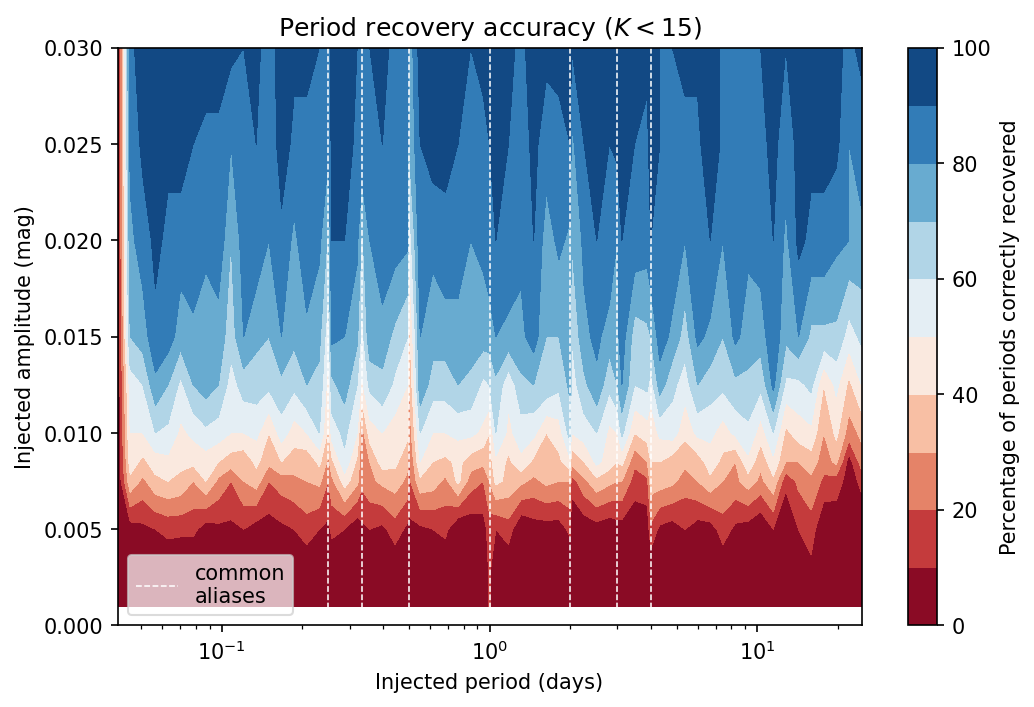

In [25]:
plt.style.use('default')

fig, ax = plt.subplots(1, figsize=(8,5), dpi=150)
plt.contourf(periods_denser, amplitudes_denser, 100*np.array(output_denser[0]).T, levels=100*np.linspace(0,1,11), cmap='RdBu')
plt.ylim(0,0.03)
plt.xlabel("Injected period (days)")
plt.ylabel("Injected amplitude (mag)")
plt.title(r"Period recovery accuracy ($K < 15$)")
plt.semilogx()
# plt.xlim(None,2.6)
cbar = plt.colorbar()
cbar.set_label("Percentage of periods correctly recovered")

for per in extra_periods:
    plt.axvline(per, lw=0.75, ls='--', color='w')
    
plt.plot([0, 0], [0, 0], lw=0.75, ls='--', color='w', label='common\naliases')
plt.legend(loc='lower left', framealpha=0.7)
    


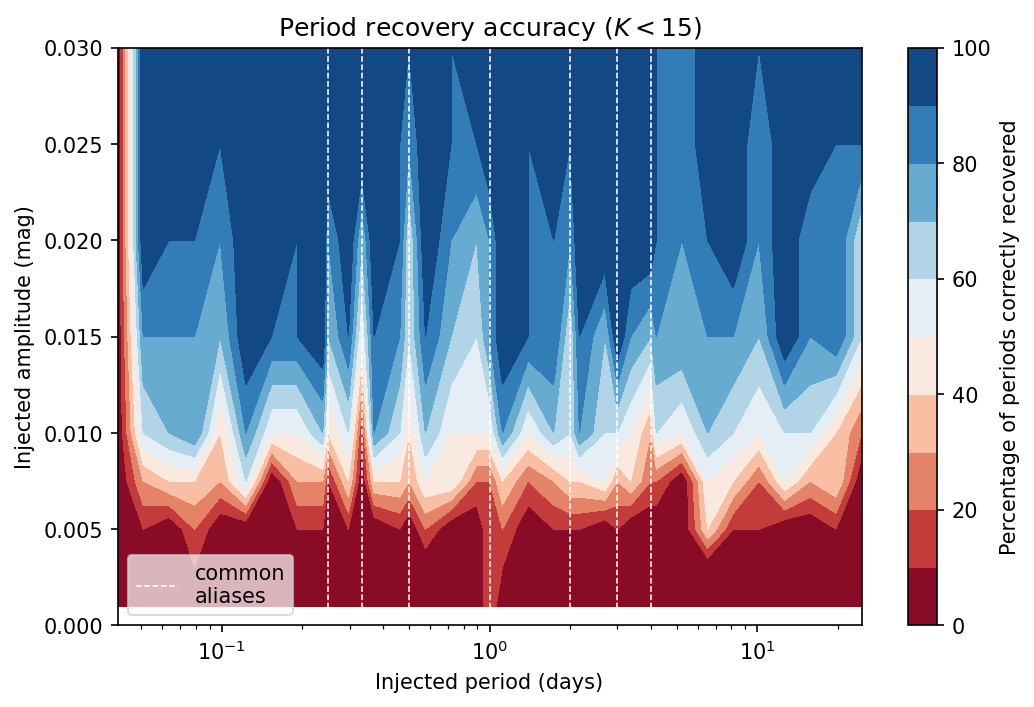

In [376]:
plt.style.use('default')


fig, ax = plt.subplots(1, figsize=(8,5), dpi=150)
plt.contourf(periods7_append_sorted, amplitudes7, 100*np.array(output7[0]).T, levels=100*np.linspace(0,1,11), cmap='RdBu')
plt.ylim(0,0.03)
plt.xlabel("Injected period (days)")
plt.ylabel("Injected amplitude (mag)")
plt.title(r"Period recovery accuracy ($K < 15$)")
plt.semilogx()
# plt.xlim(None,2.6)
cbar = plt.colorbar()
cbar.set_label("Percentage of periods correctly recovered")

for per in extra_periods:
    plt.axvline(per, lw=0.75, ls='--', color='w')
    
plt.plot([0, 0], [0, 0], lw=0.75, ls='--', color='w', label='common\naliases')
plt.legend(loc='lower left', framealpha=0.7)
    


In [461]:
plt.plot?

In [52]:
from wuvars.plotting.lightcurve import ic348_simple_lc_scatter_brokenaxes

n_nonvar = 0
for i, sid in enumerate(sids):
#     print(i, spread['variability']['Stetson_JHK'][sid])
    if 0 < spread['variability']['Stetson_JHK'][sid] <0.8:
        n_nonvar += 1
print(n_nonvar)
#     fig = ic348_simple_lc_scatter_brokenaxes(dat, sid)
#     fig.ax_j.set_title(f"IC348 {i}: {sid}")

29


In [51]:
len(output_denser[1][0][0])

40

In [54]:
def reassess_recovery_score(spread, sids, periods, amplitudes, previous_output):

    new_scores = []
    found_periods = previous_output[1]
    faps = previous_output[2]

    for i, period in enumerate(periods):

        _new_scores = []
        _found_periods = found_periods[i]
        _faps = faps[i]

        for j, amp in enumerate(amplitudes):

            __found_periods = _found_periods[j]
            __faps = _faps[j]
            correct = 0
            skip = 0

            for k, sid in enumerate(sids):

                fap = __faps[k]
                found_period = __found_periods[k]

                if 0 < spread['variability']['Stetson_JHK'][sid] < 0.8:
                    if np.abs(found_period - period) / period < 0.01:
                        correct += 1
    #                     print(f"A={amp:.2f} mag. Correct period: {found_period:.2f} v. {period:.2f}")
                    else:
    #                     print(f"A={amp:.2f} mag. Incorrect period: {found_period:.2f} v. {period:.2f}")
                        pass
                else:
                    skip +=1

                # pdb.set_trace()

#                 __found_periods.append(found_period)
#                 __faps.append(fap)

            new_score = correct / (len(sids) - skip)
            _new_scores.append(new_score)
#             _found_periods.append(__found_periods)
#             _faps.append(__faps)

        new_scores.append(_new_scores)
#         found_periods.append(_found_periods)
#         faps.append(_faps)

    return new_scores, found_periods, faps

In [56]:
output_denser_v2 = reassess_recovery_score(spread, sids, periods_denser, amplitudes_denser, output_denser)


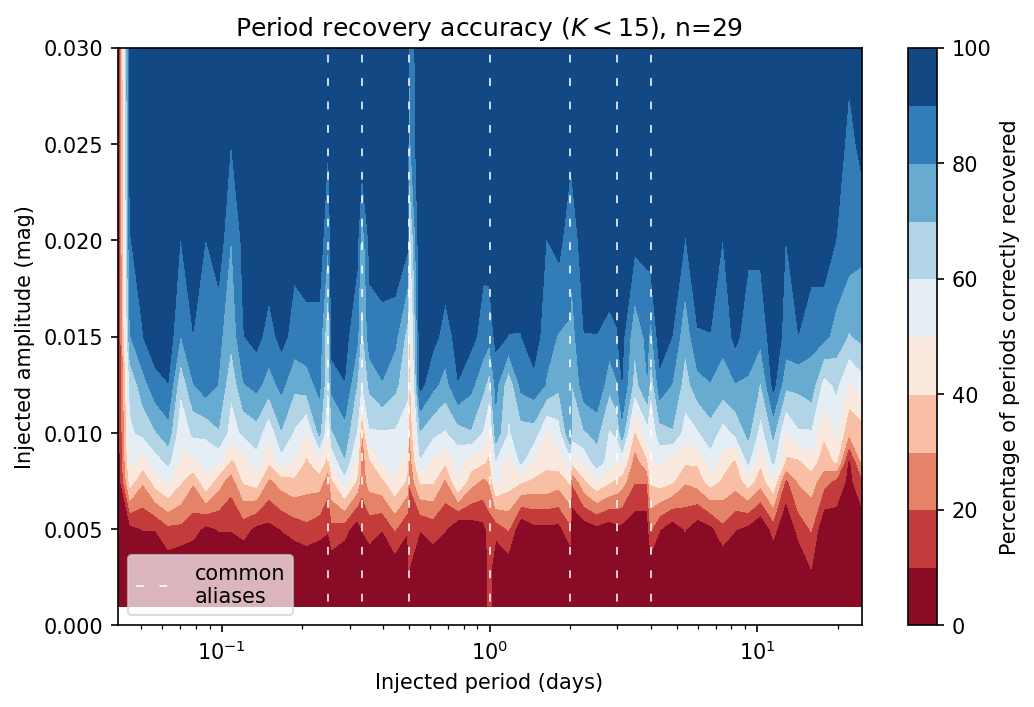

In [64]:
plt.style.use('default')

fig, ax = plt.subplots(1, figsize=(8,5), dpi=150)
plt.contourf(periods_denser, amplitudes_denser, 100*np.array(output_denser_v2[0]).T, levels=100*np.linspace(0,1,11), cmap='RdBu')
plt.ylim(0,0.03)
plt.xlabel("Injected period (days)")
plt.ylabel("Injected amplitude (mag)")
plt.title(r"Period recovery accuracy ($K < 15$), n=29")
plt.semilogx()
# plt.xlim(None,2.6)
cbar = plt.colorbar()
cbar.set_label("Percentage of periods correctly recovered")

for per in extra_periods:
    plt.axvline(per, lw=0.75, ls='--', color='w', dashes=(5, 10))
    
plt.plot([0, 0], [0, 0], lw=0.75, ls='--', color='w', dashes=(5, 10), label='common\naliases')
plt.legend(loc='lower left', framealpha=0.7)
    


[]

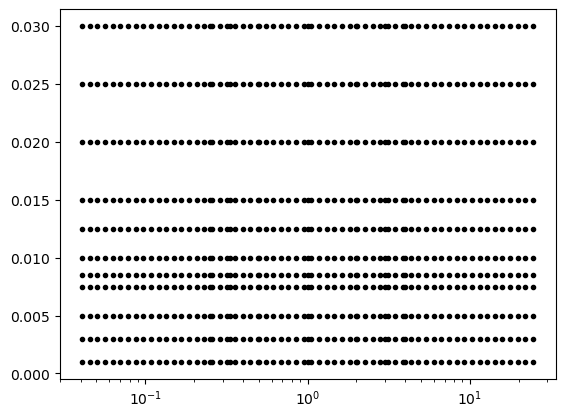

In [59]:
X_denser, Y_denser = np.meshgrid(periods_denser, amplitudes_denser)

plt.plot(X_denser, Y_denser, 'k.')
plt.semilogx()